In [44]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.stats as s
import astropy.units as u
import astropy.constants as c
import scipy.interpolate as interp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import matplotlib.offsetbox
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clip
from photutils.aperture import SkyCircularAperture, CircularAperture, ApertureStats

from spectral_cube import SpectralCube
from radio_beam import beam
from regions import Regions

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
})

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_yaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

In [45]:
B6_HCN_name = 'B6HR_comb_finalimage_HCN_natural_widechan_cb.image.pbcor'
B6_HCOp_name = 'B6HR_comb_finalimage_HCOp_natural_widechan_cb.image.pbcor'
B7_HCN_name = 'B7HR2_v3_finalimage_HCN_natural_widechan_cb.image.pbcor'
B7_HCOp_name = 'B7HR2_v3_finalimage_HCOp_natural_widechan.image.pbcor'

version = 0 # 0=own method, 1=full cube, 2=global channel mask

hdu_B6_HCN = fits.open(B6_HCN_name+'_M'+str(version)+'.fits')
hdu_B6_HCOp = fits.open(B6_HCOp_name+'_M'+str(version)+'.fits')
hdu_B7_HCN = fits.open(B7_HCN_name+'_M'+str(version)+'.fits')
hdu_B7_HCOp = fits.open(B7_HCOp_name+'_M'+str(version)+'.fits')

hdu_B6_HCN_err = fits.open(B6_HCN_name+'_dM'+str(version)+'.fits')
hdu_B6_HCOp_err = fits.open(B6_HCOp_name+'_dM'+str(version)+'.fits')
hdu_B7_HCN_err = fits.open(B7_HCN_name+'_dM'+str(version)+'.fits')
hdu_B7_HCOp_err = fits.open(B7_HCOp_name+'_dM'+str(version)+'.fits')


beam_major = hdu_B6_HCN[0].header['BMAJ'] # Beam major axis size in arcseconds
beam_minor = hdu_B6_HCN[0].header['BMIN'] # Beam minor axis size in arcseconds
beam_pa = hdu_B6_HCN[0].header['BPA']  # Beam position angle in degrees

wcs_B6 = WCS(hdu_B6_HCN[0].header)
wcs_B7 = WCS(hdu_B7_HCN[0].header)

B6_HCN = hdu_B6_HCN[0].data *u.Jy*u.km/u.s
B6_HCOp = hdu_B6_HCOp[0].data *u.Jy*u.km/u.s
B7_HCN = hdu_B7_HCN[0].data[500:1500,500:1500] *u.Jy*u.km/u.s # B7 image is twice as wide --> Also need to cut center out
B7_HCOp = hdu_B7_HCOp[0].data[500:1500,500:1500] *u.Jy*u.km/u.s

B6_HCN_err = hdu_B6_HCN_err[0].data *u.Jy*u.km/u.s
B6_HCOp_err = hdu_B6_HCOp_err[0].data *u.Jy*u.km/u.s
B7_HCN_err = hdu_B7_HCN_err[0].data[500:1500,500:1500] *u.Jy*u.km/u.s
B7_HCOp_err = hdu_B7_HCOp_err[0].data[500:1500,500:1500] *u.Jy*u.km/u.s

beam_major_pix = hdu_B7_HCOp[0].header['BMAJ']*3.6e6/3 # Beam major axis size in pixels
beam_minor_pix = hdu_B7_HCOp[0].header['BMIN']*3.6e6/3 # Beam minor axis size in pixels

hdu_B6_HCN.close()
hdu_B6_HCOp.close()
hdu_B7_HCN.close()
hdu_B7_HCOp.close()

hdu_B6_HCN_err.close()
hdu_B6_HCOp_err.close()
hdu_B7_HCN_err.close()
hdu_B7_HCOp_err.close()

In [46]:
SNR_B6_HCN = B6_HCN/B6_HCN_err
SNR_B6_HCOp = B6_HCOp/B6_HCOp_err
SNR_B7_HCN = B7_HCN/B7_HCN_err
SNR_B7_HCOp = B7_HCOp/B7_HCOp_err

clip = 3 # We clip at 3 sigma since Serena told me you need at least 3
totalmask = (SNR_B6_HCN>clip) & (SNR_B6_HCOp>clip) & (SNR_B7_HCN>clip) & (SNR_B7_HCOp>clip) # just as diagnostic

B6_HCN_clip = np.copy(B6_HCN)
B6_HCOp_clip = np.copy(B6_HCOp)
B7_HCN_clip = np.copy(B7_HCN)
B7_HCOp_clip = np.copy(B7_HCOp)

B6_HCN_clip[SNR_B6_HCN<clip] = np.nan
B6_HCOp_clip[SNR_B6_HCOp<clip] = np.nan
B7_HCN_clip[SNR_B7_HCN<clip] = np.nan
B7_HCOp_clip[SNR_B7_HCOp<clip] = np.nan

B6_HCN_clip[B6_HCN_clip==0] = np.nan
B6_HCOp_clip[B6_HCOp_clip==0] = np.nan
B7_HCN_clip[B7_HCN_clip==0] = np.nan
B7_HCOp_clip[B7_HCOp_clip==0] = np.nan

cmap = mpl.cm.get_cmap('jet')
cmap2 = mpl.cm.get_cmap('inferno')

norm_I = mpl.colors.LogNorm(vmin=5e-2, vmax=2.5e0)
sm_I = cm.ScalarMappable(norm=norm_I, cmap=cmap2)
norm_I_zoom = mpl.colors.LogNorm(vmin=5e-2, vmax=2.5e0)
sm_I_zoom = cm.ScalarMappable(norm=norm_I_zoom, cmap=cmap2)

C:\Users\woutg\anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


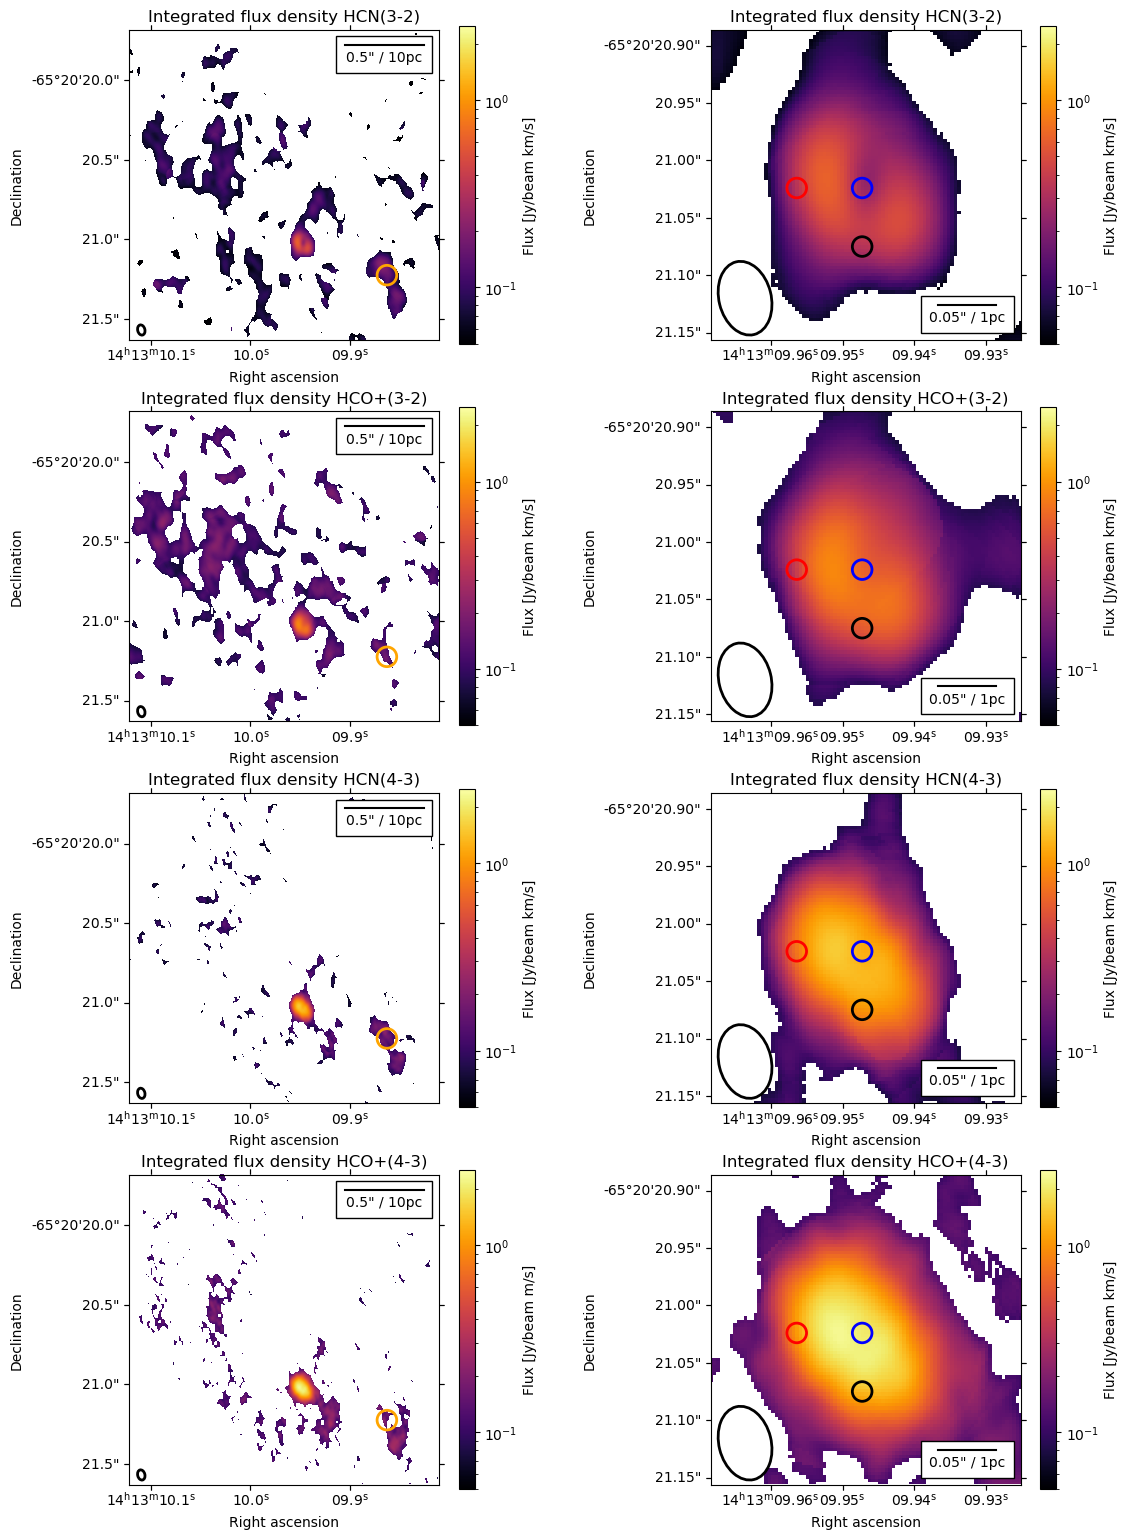

In [47]:
fig, ax = plt.subplots(4, 2, figsize=(12.5,19), subplot_kw={'projection': wcs_B6}) #horizontal size: 25,9.5

ra, dec = 150, 320
ra_zoom, dec_zoom = 455, 470

beam_HCN_00 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_01 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_02 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_03 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_10 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_11 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_12 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_13 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)

ax[0,0].imshow(B6_HCN_clip.value, origin='lower', cmap='inferno', norm=norm_I)
ax[0,0].set_title('Integrated flux density HCN(3-2)')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
ax[0,0].add_patch(beam_HCN_00)
ax[0,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[0,0].set_xlim(125,775)
ax[0,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[0,0], linekw=dict(color="black"))
ax[0,0].add_artist(ob)
fig.colorbar(mappable=sm_I, ax=ax[0,0], label='Flux [Jy/beam km/s]')

ax[1,0].imshow(B6_HCOp_clip.value, origin='lower', cmap='inferno', norm=norm_I)
ax[1,0].set_title('Integrated flux density HCO+(3-2)')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
ax[1,0].add_patch(beam_HCN_01)
ax[1,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[1,0].set_xlim(125,775)
ax[1,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[1,0], linekw=dict(color="black"))
ax[1,0].add_artist(ob)
fig.colorbar(mappable=sm_I, ax=ax[1,0], label='Flux [Jy/beam km/s]')

ax[2,0].imshow(B7_HCN_clip.value, origin='lower', cmap='inferno', norm=norm_I)
ax[2,0].set_title('Integrated flux density HCN(4-3)')
ax[2,0].set_xlabel('Right ascension')
ax[2,0].set_ylabel('Declination')
ax[2,0].add_patch(beam_HCN_02)
ax[2,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[2,0].set_xlim(125,775)
ax[2,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[2,0], linekw=dict(color="black"))
ax[2,0].add_artist(ob)
fig.colorbar(mappable=sm_I, ax=ax[2,0], label='Flux [Jy/beam km/s]')

ax[3,0].imshow(B7_HCOp_clip.value, origin='lower', cmap='inferno', norm=norm_I)
ax[3,0].set_title('Integrated flux density HCO+(4-3)')
ax[3,0].set_xlabel('Right ascension')
ax[3,0].set_ylabel('Declination')
ax[3,0].add_patch(beam_HCN_03)
ax[3,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[3,0].set_xlim(125,775)
ax[3,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[3,0], linekw=dict(color="black"))
ax[3,0].add_artist(ob)
fig.colorbar(mappable=sm_I, ax=ax[3,0], label='Flux [Jy/beam m/s]')

#################################
ax[0,1].imshow(B6_HCN_clip.value, origin='lower', cmap='inferno', norm=norm_I_zoom)
ax[0,1].set_title('Integrated flux density HCN(3-2)')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
ax[0,1].set_xlim(445,535)
ax[0,1].set_ylim(458,548)
ax[0,1].add_patch(beam_HCN_10)
ax[0,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[0,1].scatter(489, 485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[0,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[0,1], linekw=dict(color="black"))
ax[0,1].add_artist(ob)
fig.colorbar(mappable=sm_I_zoom, ax=ax[0,1], label='Flux [Jy/beam km/s]')

ax[1,1].imshow(B6_HCOp_clip.value, origin='lower', cmap='inferno', norm=norm_I_zoom)
ax[1,1].set_title('Integrated flux density HCO+(3-2)')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
ax[1,1].set_xlim(445,535)
ax[1,1].set_ylim(458,548)
ax[1,1].add_patch(beam_HCN_11)
ax[1,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[1,1].scatter(489, 485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[1,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[1,1], linekw=dict(color="black"))
ax[1,1].add_artist(ob)
fig.colorbar(mappable=sm_I_zoom, ax=ax[1,1], label='Flux [Jy/beam km/s]')

ax[2,1].imshow(B7_HCN_clip.value, origin='lower', cmap='inferno', norm=norm_I_zoom)
ax[2,1].set_title('Integrated flux density HCN(4-3)')
ax[2,1].set_xlabel('Right ascension')
ax[2,1].set_ylabel('Declination')
ax[2,1].set_xlim(445,535)
ax[2,1].set_ylim(458,548)
ax[2,1].add_patch(beam_HCN_12)
ax[2,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[2,1].scatter(489, 485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[2,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[2,1], linekw=dict(color="black"))
ax[2,1].add_artist(ob)
fig.colorbar(mappable=sm_I_zoom, ax=ax[2,1], label='Flux [Jy/beam km/s]')

ax[3,1].imshow(B7_HCOp_clip.value, origin='lower', cmap='inferno', norm=norm_I_zoom)
ax[3,1].set_title('Integrated flux density HCO+(4-3)')
ax[3,1].set_xlabel('Right ascension')
ax[3,1].set_ylabel('Declination')
ax[3,1].set_xlim(445,535)
ax[3,1].set_ylim(458,548)
ax[3,1].add_patch(beam_HCN_13)
ax[3,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[3,1].scatter(489, 485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[3,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[3,1], linekw=dict(color="black"))
ax[3,1].add_artist(ob)
fig.colorbar(mappable=sm_I_zoom, ax=ax[3,1], label='Flux [Jy/beam km/s]')

plt.subplots_adjust(wspace=0.5)
plt.savefig('LTE_input_vertical.pdf', bbox_inches='tight')

# LTE Radiative Transfer Magic:

In [48]:
#beamsize:
cb_omega = np.pi*((1.810397297783E-05*u.degree).to(u.rad).value)*((1.263968233633E-05*u.degree).to(u.rad).value)

A_B6_HCN = 10**(-3.078) /u.s #Ortho at 200K
A_B6_HCOp = 10**(-2.8376) /u.s #Ortho at 200K
A_B7_HCN = 10**(-2.6874) /u.s #Ortho at 200K
A_B7_HCOp = 10**(-2.4471) /u.s #Ortho at 200K

In [49]:
#Assuming optically thin:
def column_dens_thin(mom0, A, omega):
    numerator = 4*np.pi*mom0
    denomenator = A*omega*c.h*c.c
    coldens = (numerator/denomenator).to(u.cm**(-2))
    return coldens

#10−23 erg⋅s−1⋅cm−2⋅Hz−1

In [50]:
coldens_B6_HCN = column_dens_thin(B6_HCN_clip, A_B6_HCN, cb_omega)
coldens_B6_HCOp = column_dens_thin(B6_HCOp_clip, A_B6_HCOp, cb_omega)
coldens_B7_HCN = column_dens_thin(B7_HCN_clip, A_B7_HCN, cb_omega)
coldens_B7_HCOp = column_dens_thin(B7_HCOp_clip, A_B7_HCOp, cb_omega)

In [51]:
g_B6 = 7
g_B7 = 9


freq_B6_HCN = 265886.4339 *1e6*u.Hz*c.h
freq_B6_HCOp = 267557.6259 *1e6*u.Hz*c.h
freq_B7_HCN = 354505.4773 *1e6*u.Hz*c.h
freq_B7_HCOp = 356734.2230 *1e6*u.Hz*c.h

El_B6_HCN = 8.8692 *u.cm**(-1)*c.h*c.c
El_B6_HCOp = 8.9250 *u.cm**(-1)*c.h*c.c
El_B7_HCN = 17.7382 *u.cm**(-1)*c.h*c.c
El_B7_HCOp = 17.8497 *u.cm**(-1)*c.h*c.c

Eu_B6_HCN = ((El_B6_HCN+freq_B6_HCN)/c.k_B).to(u.K)
Eu_B6_HCOp = ((El_B6_HCOp+freq_B6_HCOp)/c.k_B).to(u.K)
Eu_B7_HCN = ((El_B7_HCN+freq_B7_HCN)/c.k_B).to(u.K)
Eu_B7_HCOp = ((El_B7_HCOp+freq_B7_HCOp)/c.k_B).to(u.K)

print(Eu_B6_HCN, Eu_B6_HCOp, Eu_B7_HCN, Eu_B7_HCOp)

25.521336143924096 K 25.681824459991464 K 42.53489157256439 K 42.80227811803626 K


In [52]:
rot_ratio_HCN = (np.log(coldens_B6_HCN.value/g_B6)-np.log(coldens_B7_HCN.value/g_B7))/(Eu_B6_HCN.value-Eu_B7_HCN.value)
rot_ratio_HCOp = (np.log(coldens_B6_HCOp.value/g_B6)-np.log(coldens_B7_HCOp.value/g_B7))/(Eu_B6_HCOp.value-Eu_B7_HCOp.value)

Tk_HCN = -u.K/rot_ratio_HCN
Tk_HCOp = -u.K/rot_ratio_HCOp

In [62]:
norm_T = mpl.colors.LogNorm(vmin=1e1, vmax=1e3)
norm_T_rat = mpl.colors.LogNorm(vmin=1e-1, vmax=1e1)
norm_d = mpl.colors.LogNorm(vmin=1e14, vmax=1e16)
norm_d_rat = mpl.colors.LogNorm(vmin=1e0, vmax=2e1)

sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
sm_T_rat = cm.ScalarMappable(norm=norm_T_rat, cmap=cmap)
sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)
sm_d_rat = cm.ScalarMappable(norm=norm_d_rat, cmap=cmap)

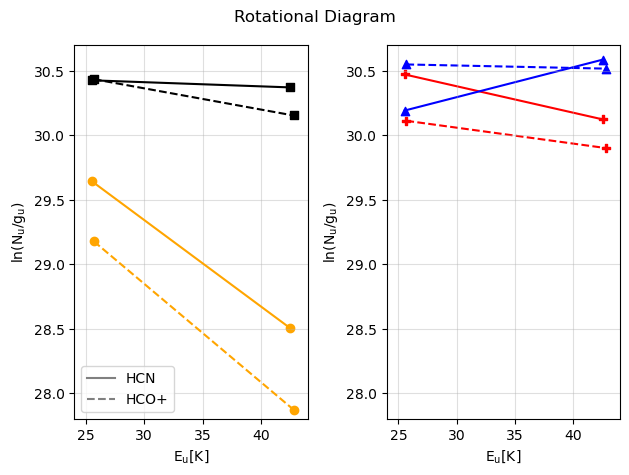

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Rotational Diagram')

rot_x, rot_y = 470,503

ax2.scatter([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)], color='red',marker='P', zorder=0)
ax2.plot([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)], color='red',zorder=0)
ax2.scatter([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)], color='red',marker='P',zorder=0)
ax2.plot([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)], linestyle='dashed', color='red',zorder=0)

rot_x, rot_y = 489,502

ax2.scatter([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)], color='blue',marker='^',zorder=1)
ax2.plot([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)], color='blue',zorder=1)
ax2.scatter([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)], color='blue',marker='^',zorder=1)
ax2.plot([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)], linestyle='dashed', color='blue',zorder=1)

rot_x, rot_y = 489, 485
ax1.scatter([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)],marker='s', color='black')
ax1.plot([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)], color='black')
ax1.scatter([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)],marker='s', color='black')
ax1.plot([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)], linestyle='dashed', color='black')

ax1.plot([0,1],[0,1], label='HCN', color='grey')
ax1.plot([0,1],[0,1], label='HCO+', linestyle='dashed', color='grey')

rot_x, rot_y = 665,435
ax1.scatter([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)], color='orange')
ax1.plot([Eu_B6_HCN.value,Eu_B7_HCN.value],[np.log(coldens_B6_HCN[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCN[rot_y, rot_x].value/g_B7)], color='orange')
ax1.scatter([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)], color='orange')
ax1.plot([Eu_B6_HCOp.value,Eu_B7_HCOp.value],[np.log(coldens_B6_HCOp[rot_y, rot_x].value/g_B6),np.log(coldens_B7_HCOp[rot_y, rot_x].value/g_B7)], linestyle='dashed', color='orange')


ax1.grid(alpha=0.4)
ax2.grid(alpha=0.4)

ax1.set_xlabel(r'E$_{\mathrm{u}}$[K]')
ax2.set_xlabel(r'E$_{\mathrm{u}}$[K]')

ax1.set_xlim(24,44)
ax2.set_xlim(24,44)
ax1.set_ylim(27.8,30.7)
ax2.set_ylim(27.8,30.7)

ax1.set_ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')
ax2.set_ylabel(r'ln(N$_{\mathrm{u}}$/g$_{\mathrm{u}}$)')

ax1.legend()

plt.tight_layout()
plt.savefig(fname='rotdiagrams_2.pdf')

In [64]:
Z_log_HCN = np.array([3.5198, 2.9688, 2.6566, 2.5122, 2.3286, 2.0286, 1.7317,1.4389, 1.1545, 0.9109, 0.7016])
Z_log_HCOp = np.array([np.nan, 2.4426, 2.1638, 2.0276, 1.8481, 1.5488, 1.2519, 0.9592, 0.6748, 0.4315, 0.2225])
T = np.array([1000,500,300,225,150,75,37.5,18.75,9.375,5.000,2.725])

temp_behaved_mask_HCN = (Tk_HCN.value<1000) & (Tk_HCN.value>2.725)
temp_behaved_mask_HCOp = (Tk_HCOp.value<500) & (Tk_HCOp.value>2.725)

Tk_HCN_behaved = np.copy(Tk_HCN)
Tk_HCOp_behaved = np.copy(Tk_HCOp)
Tk_HCN_behaved[np.logical_not(temp_behaved_mask_HCN)] = np.nan
Tk_HCOp_behaved[np.logical_not(temp_behaved_mask_HCOp)] = np.nan

Z_interp_HCN = interp.interp1d(T, 10**Z_log_HCN, kind='linear')
Z_interp_HCOp = interp.interp1d(T, 10**Z_log_HCOp, kind='linear')

Z_HCN = Z_interp_HCN(Tk_HCN_behaved)
Z_HCOp = Z_interp_HCOp(Tk_HCOp_behaved)

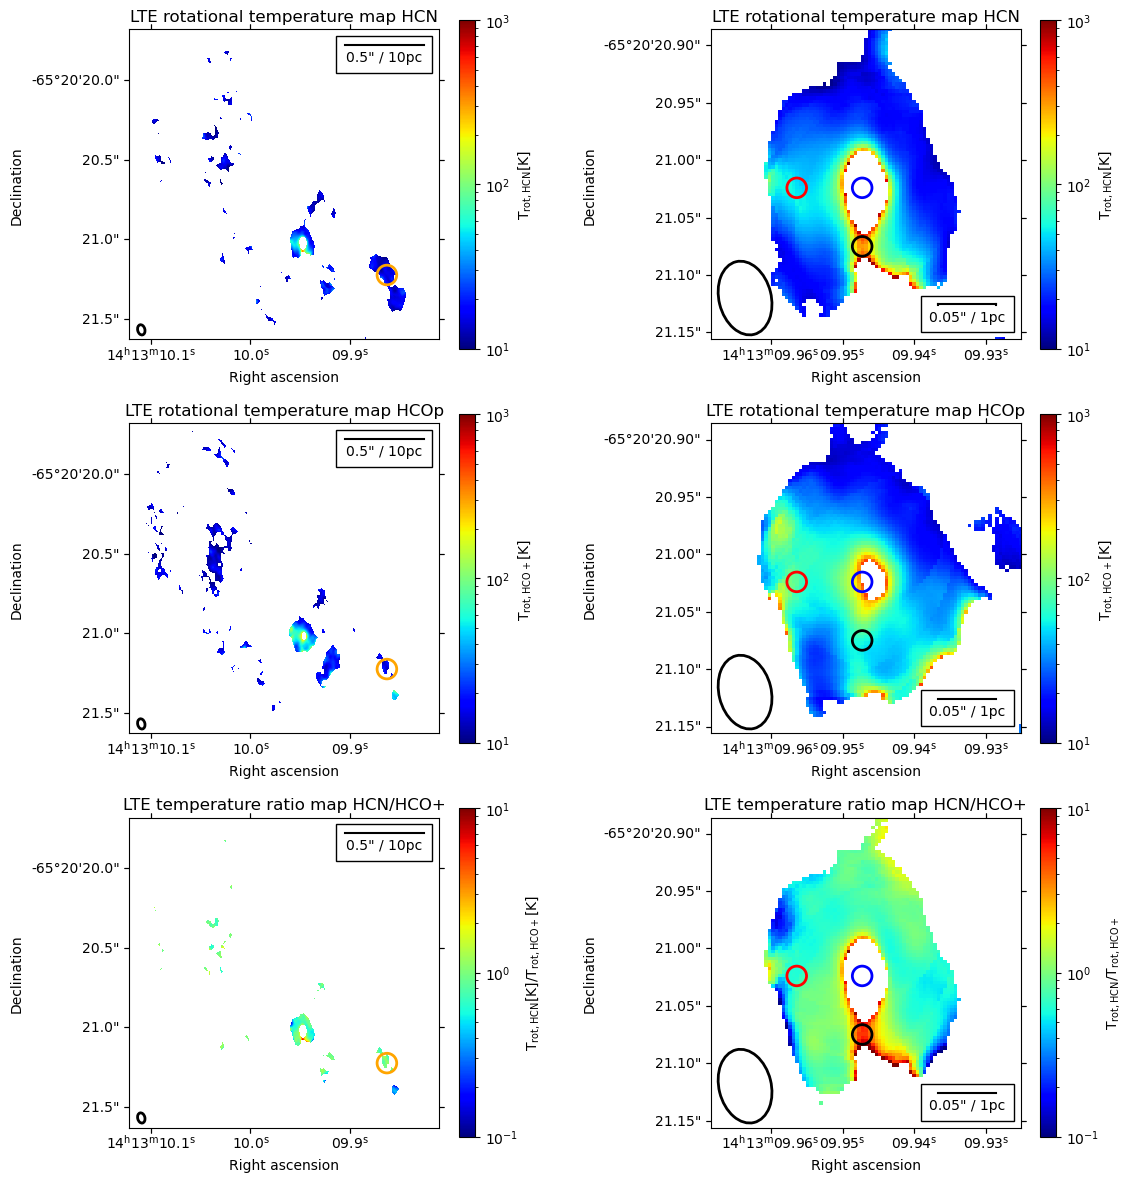

In [65]:
fig, ax = plt.subplots(3, 2, figsize=(12.5,14.5), subplot_kw={'projection': wcs_B6}) #size horizontal: 20,9.5

beam_HCN_00 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_01 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_02 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_10 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_11 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_12 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)

ax[0,0].imshow(Tk_HCN_behaved.value, origin='lower', cmap='jet', norm=norm_T)
ax[0,0].set_title('LTE rotational temperature map HCN')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
ax[0,0].add_patch(beam_HCN_00)
ax[0,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[0,0].set_xlim(125,775)
ax[0,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[0,0], linekw=dict(color="black")) 
ax[0,0].add_artist(ob)
fig.colorbar(mappable=sm_T, ax=ax[0,0], label='T$_{\mathrm{rot,HCN}}$[K]')

ax[1,0].imshow(Tk_HCOp_behaved.value, origin='lower', cmap='jet', norm=norm_T)
ax[1,0].set_title('LTE rotational temperature map HCOp')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
ax[1,0].add_patch(beam_HCN_01)
ax[1,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[1,0].set_xlim(125,775)
ax[1,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[1,0], linekw=dict(color="black")) 
ax[1,0].add_artist(ob)
fig.colorbar(mappable=sm_T, ax=ax[1,0], label='T$_{\mathrm{rot,HCO+}}$[K]')

ax[2,0].imshow(Tk_HCN_behaved.value/Tk_HCOp_behaved.value, origin='lower', cmap='jet', norm=norm_T_rat)
ax[2,0].set_title('LTE temperature ratio map HCN/HCO+')
ax[2,0].set_xlabel('Right ascension')
ax[2,0].set_ylabel('Declination')
ax[2,0].add_patch(beam_HCN_02)
ax[2,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[2,0].set_xlim(125,775)
ax[2,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[2,0], linekw=dict(color="black")) 
ax[2,0].add_artist(ob)
fig.colorbar(mappable=sm_T_rat, ax=ax[2,0], label='T$_{\mathrm{rot,HCN}}$[K]/T$_{\mathrm{rot,HCO+}}$[K]')

#################################
ax[0,1].imshow(Tk_HCN_behaved.value, origin='lower', cmap='jet', norm=norm_T)
ax[0,1].set_title('LTE rotational temperature map HCN')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
ax[0,1].set_xlim(445,535)
ax[0,1].set_ylim(458,548)
ax[0,1].add_patch(beam_HCN_10)
ax[0,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[0,1].scatter(489,485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[0,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[0,1], linekw=dict(color="black")) 
ax[0,1].add_artist(ob)
fig.colorbar(mappable=sm_T, ax=ax[0,1], label=r'T$_{\mathrm{rot,HCN}}$[K]')

ax[1,1].imshow(Tk_HCOp_behaved.value, origin='lower', cmap='jet', norm=norm_T)
ax[1,1].set_title('LTE rotational temperature map HCOp')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
ax[1,1].set_xlim(445,535)
ax[1,1].set_ylim(458,548)
ax[1,1].add_patch(beam_HCN_11)
ax[1,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[1,1].scatter(489,485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[1,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[1,1], linekw=dict(color="black")) 
ax[1,1].add_artist(ob)
fig.colorbar(mappable=sm_T, ax=ax[1,1], label='T$_{\mathrm{rot,HCO+}}$[K]')

ax[2,1].imshow(Tk_HCN_behaved.value/Tk_HCOp_behaved.value, origin='lower', cmap='jet', norm=norm_T_rat)
ax[2,1].set_title('LTE temperature ratio map HCN/HCO+')
ax[2,1].set_xlabel('Right ascension')
ax[2,1].set_ylabel('Declination')
ax[2,1].set_xlim(445,535)
ax[2,1].set_ylim(458,548)
ax[2,1].add_patch(beam_HCN_12)
ax[2,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[2,1].scatter(489,485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[2,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[2,1], linekw=dict(color="black")) 
ax[2,1].add_artist(ob)
fig.colorbar(mappable=sm_T_rat, ax=ax[2,1], label='T$_{\mathrm{rot,HCN}}$/T$_{\mathrm{rot,HCO+}}$')
plt.subplots_adjust(wspace=0.5)
plt.savefig('LTE_tempmaps_vertical.pdf', bbox_inches='tight')

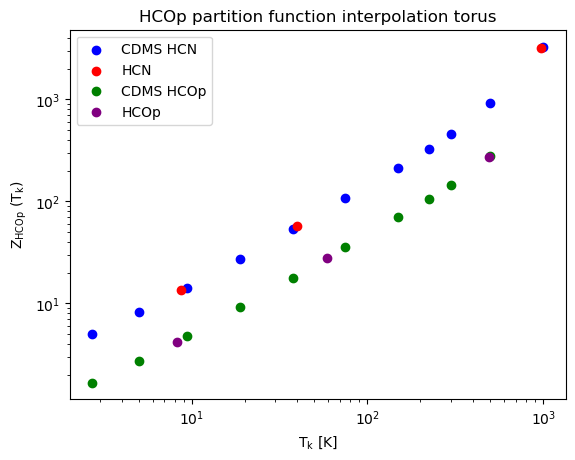

In [66]:
plt.scatter(T, 10**Z_log_HCN, color='blue', label='CDMS HCN')
plt.scatter(Tk_HCN_behaved.value[500,500],Z_HCN[500,500], label='HCN', color='red')
plt.scatter(np.nanmin(Tk_HCN_behaved.value),np.nanmin(Z_HCN), color='red')
plt.scatter(np.nanmax(Tk_HCN_behaved.value),np.nanmax(Z_HCN), color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T$_\mathrm{k}$ [K]')
plt.ylabel(r'Z$_{HCN}$ (T$_\mathrm{k}$)')
plt.legend()
plt.title('HCN partition function interpolation torus')

plt.scatter(T, 10**Z_log_HCOp, color='green', label='CDMS HCOp')
plt.scatter(Tk_HCOp_behaved.value[500,500],Z_HCOp[500,500], label='HCOp', color='purple')
plt.scatter(np.nanmin(Tk_HCOp_behaved.value),np.nanmin(Z_HCOp), color='purple')
plt.scatter(np.nanmax(Tk_HCOp_behaved.value),np.nanmax(Z_HCOp), color='purple')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T$_\mathrm{k}$ [K]')
plt.ylabel(r'Z$_{HCOp}$ (T$_\mathrm{k}$)')
plt.legend()
plt.title('HCOp partition function interpolation torus')

plt.show()

In [67]:
def N_tot(N_u, g_u, Z, E_u, Tk):
    return N_u*Z*np.exp(E_u/Tk)/g_u

In [68]:
N_B6_HCN = N_tot(coldens_B6_HCN, g_B6, Z_HCN, Eu_B6_HCN, Tk_HCN_behaved)
N_B6_HCOp = N_tot(coldens_B6_HCOp, g_B6, Z_HCOp, Eu_B6_HCOp, Tk_HCOp_behaved)
N_B7_HCN = N_tot(coldens_B7_HCN, g_B7, Z_HCN, Eu_B7_HCN, Tk_HCN_behaved)
N_B7_HCOp = N_tot(coldens_B7_HCOp, g_B7, Z_HCOp, Eu_B7_HCOp, Tk_HCOp_behaved)

In [69]:
print(N_B6_HCN[500,500], coldens_B6_HCN[500,500], coldens_B6_HCOp[500,500])
print(N_B7_HCN[500,500], coldens_B7_HCN[500,500], coldens_B7_HCOp[500,500])

2255989481889942.5 1 / cm2 145813550864628.34 1 / cm2 115796205304333.33 1 / cm2
2255989481889945.5 1 / cm2 121932571509093.83 1 / cm2 111332005795303.28 1 / cm2


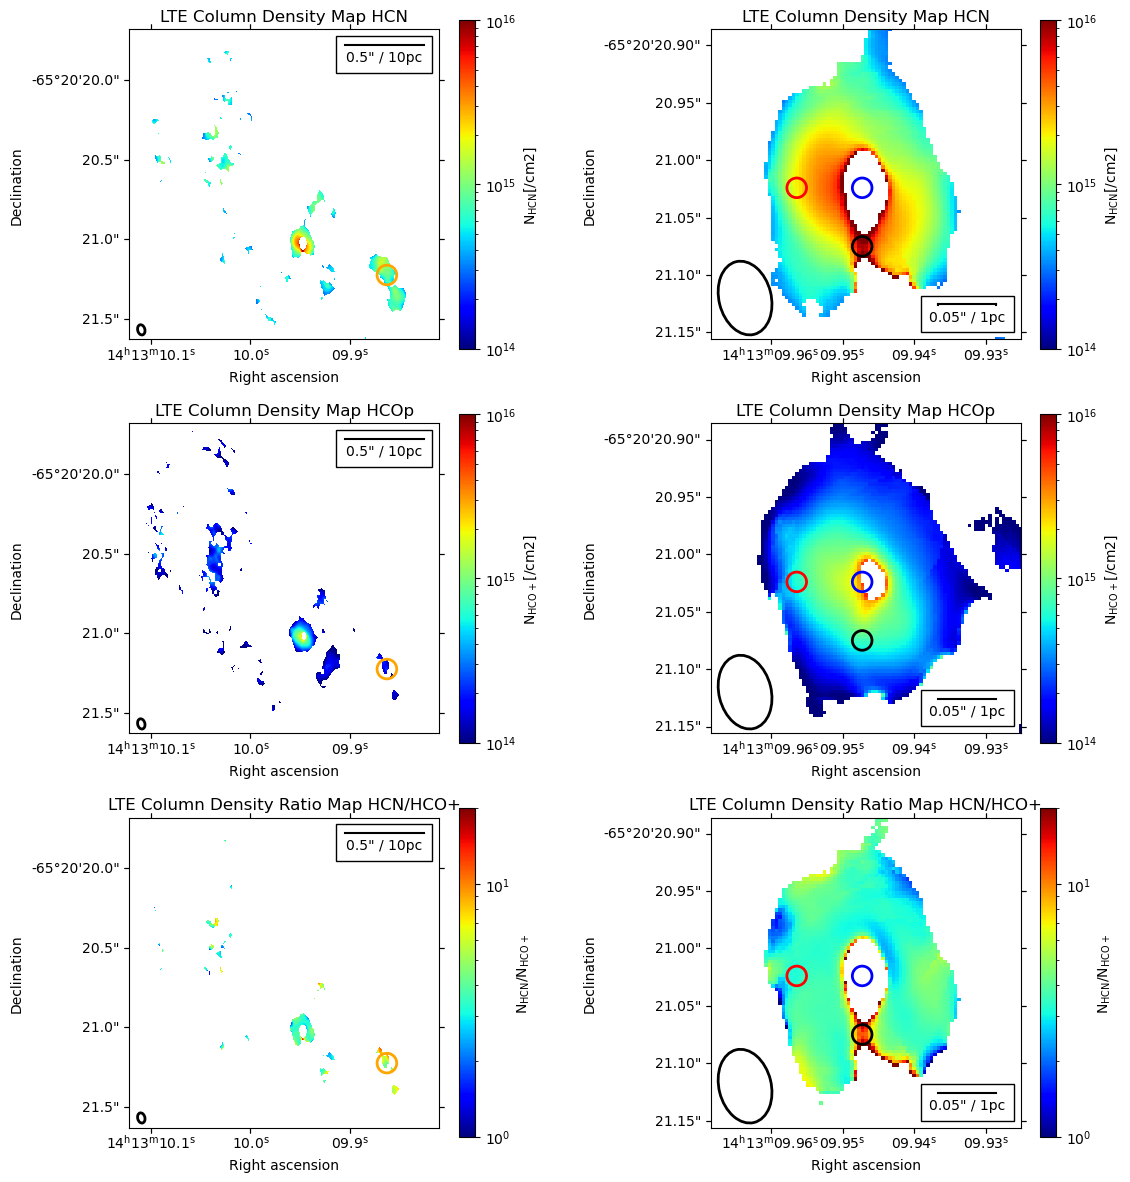

In [70]:
fig, ax = plt.subplots(3, 2, figsize=(12.5,14.5), subplot_kw={'projection': wcs_B6}) #size horizontal: 20,9.5

beam_HCN_00 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_01 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_02 = Ellipse((ra, dec), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_10 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_11 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_12 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)

ax[0,0].imshow(N_B6_HCN.value, origin='lower', cmap='jet', norm=norm_d)
ax[0,0].set_title('LTE Column Density Map HCN')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
ax[0,0].add_patch(beam_HCN_00)
ax[0,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[0,0].set_xlim(125,775)
ax[0,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[0,0], linekw=dict(color="black")) 
ax[0,0].add_artist(ob)
fig.colorbar(mappable=sm_d, ax=ax[0,0], label='N$_{\mathrm{HCN}}$[/cm2]')

ax[1,0].imshow(N_B6_HCOp.value, origin='lower', cmap='jet', norm=norm_d)
ax[1,0].set_title('LTE Column Density Map HCOp')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
ax[1,0].add_patch(beam_HCN_01)
ax[1,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[1,0].set_xlim(125,775)
ax[1,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[1,0], linekw=dict(color="black")) 
ax[1,0].add_artist(ob)
fig.colorbar(mappable=sm_d, ax=ax[1,0], label='N$_{\mathrm{HCO+}}$[/cm2]')

ax[2,0].imshow(N_B6_HCN.value/N_B6_HCOp.value, origin='lower', cmap='jet', norm=norm_d_rat)
ax[2,0].set_title('LTE Column Density Ratio Map HCN/HCO+')
ax[2,0].set_xlabel('Right ascension')
ax[2,0].set_ylabel('Declination')
ax[2,0].add_patch(beam_HCN_02)
ax[2,0].scatter(665,435,s=200, facecolors='none', edgecolors='orange', linewidth=2)
ax[2,0].set_xlim(125,775)
ax[2,0].set_ylim(300,950)
ob = AnchoredHScaleBar(size=0.2567, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[2,0], linekw=dict(color="black")) 
ax[2,0].add_artist(ob)
fig.colorbar(mappable=sm_d_rat, ax=ax[2,0], label='N$_{\mathrm{HCN}}$/N$_{\mathrm{HCO+}}$')

#################################
ax[0,1].imshow(N_B6_HCN.value, origin='lower', cmap='jet', norm=norm_d)
ax[0,1].set_title('LTE Column Density Map HCN')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
ax[0,1].set_xlim(445,535)
ax[0,1].set_ylim(458,548)
ax[0,1].add_patch(beam_HCN_10)
ax[0,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[0,1].scatter(489,485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[0,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[0,1], linekw=dict(color="black")) 
ax[0,1].add_artist(ob)
fig.colorbar(mappable=sm_d, ax=ax[0,1], label='N$_{\mathrm{HCN}}$[/cm2]')

ax[1,1].imshow(N_B6_HCOp.value, origin='lower', cmap='jet', norm=norm_d)
ax[1,1].set_title('LTE Column Density Map HCOp')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
ax[1,1].set_xlim(445,535)
ax[1,1].set_ylim(458,548)
ax[1,1].add_patch(beam_HCN_11)
ax[1,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[1,1].scatter(489,485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[1,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[1,1], linekw=dict(color="black")) 
ax[1,1].add_artist(ob)
fig.colorbar(mappable=sm_d, ax=ax[1,1], label='N$_{\mathrm{HCO+}}$[/cm2]')

ax[2,1].imshow(N_B6_HCN.value/N_B6_HCOp.value, origin='lower', cmap='jet', norm=norm_d_rat)
ax[2,1].set_title('LTE Column Density Ratio Map HCN/HCO+')
ax[2,1].set_xlabel('Right ascension')
ax[2,1].set_ylabel('Declination')
ax[2,1].set_xlim(445,535)
ax[2,1].set_ylim(458,548)
ax[2,1].add_patch(beam_HCN_12)
ax[2,1].scatter(470,502,s=200, facecolors='none', edgecolors='red', linewidth=2)
ax[2,1].scatter(489,485,s=200, facecolors='none', edgecolors='black', linewidth=2)
ax[2,1].scatter(489,502,s=200, facecolors='none', edgecolors='blue', linewidth=2)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[2,1], linekw=dict(color="black")) 
ax[2,1].add_artist(ob)
fig.colorbar(mappable=sm_d_rat, ax=ax[2,1], label=r'N$_{\mathrm{HCN}}$/N$_{\mathrm{HCO+}}$')
plt.subplots_adjust(wspace=0.5)
plt.savefig('LTE_coldensmaps_vertical.pdf', bbox_inches='tight')

In [71]:
print(Tk_HCN.value[435,665])
print(Tk_HCOp.value[435,665])

print("{:.2E}".format(N_B6_HCN.value[435,665]))
print("{:.2E}".format(N_B6_HCOp.value[435,665]))

print(Tk_HCN.value[503,470])
print(Tk_HCOp.value[503,470])

print("{:.2E}".format(N_B6_HCN.value[503,470]))
print("{:.2E}".format(N_B6_HCOp.value[503,470]))

print(Tk_HCN.value[481,489])
print(Tk_HCOp.value[481,489])

print("{:.2E}".format(N_B6_HCN.value[485,489]))
print("{:.2E}".format(N_B6_HCOp.value[485,489]))

print(Tk_HCN.value[502,489])
print(Tk_HCOp.value[502,489])

print(B6_HCN_clip.value[502,489])
print(B7_HCN_clip.value[502,489])

print("{:.2E}".format(N_B6_HCN.value[502,489]))
print("{:.2E}".format(N_B6_HCOp.value[502,489]))

14.9290499191806
13.122333797553571
9.12E+14
2.15E+14
48.72002862466002
80.90698762670192
2.02E+15
6.26E+14
-2271.843163557057
52.43003704942885
8.45E+15
7.24E+14
-43.02503140397201
529.1463767612189
0.26201356220585703
1.229710825723246
NAN
NAN


0.8876222962111651
0.8376410218944855
15.16976653572319
15.361945874176836
35.59348697281836


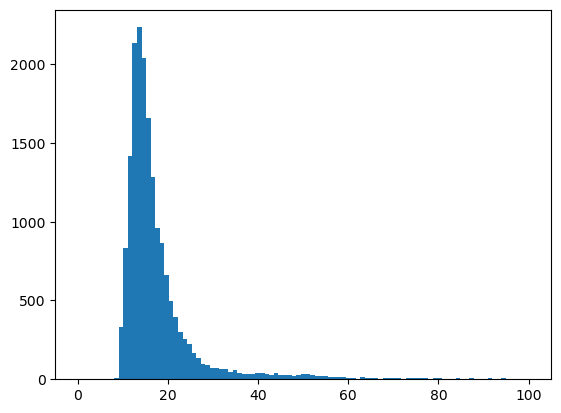

[]

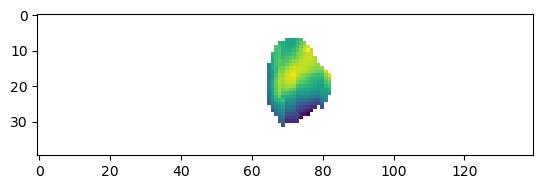

In [72]:
print(np.nanmedian(Tk_HCN_behaved.value/Tk_HCOp_behaved.value))
print(np.nanstd(Tk_HCN_behaved.value/Tk_HCOp_behaved.value))

print(np.nanmedian(Tk_HCN_behaved.value))
print(np.nanmedian(Tk_HCOp_behaved.value))
print(np.nanstd(Tk_HCN_behaved.value))

plt.hist(np.ndarray.flatten(Tk_HCN_behaved.value), bins=np.linspace(0,100,100))
plt.show()

plt.imshow(Tk_HCN_behaved[360:400,610:750].value/Tk_HCOp_behaved[360:400,610:750].value)
#plt.xlim(600,750)
#plt.ylim(350,410)
plt.plot()

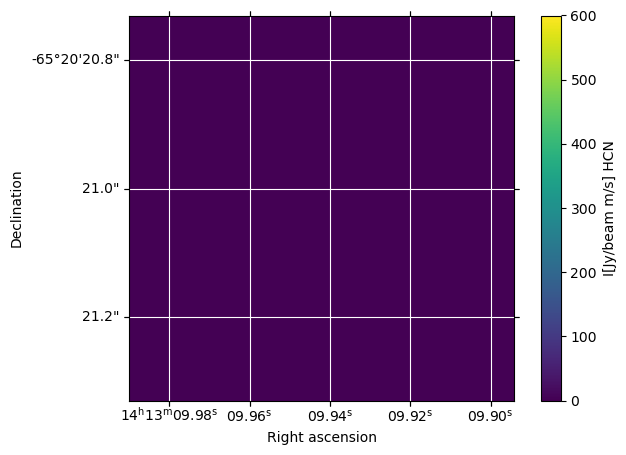

In [73]:
plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(B6_HCN.value, vmin=0, vmax=600, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.xlim(400,600)
plt.ylim(400,600)
plt.colorbar(label='I[Jy/beam m/s] HCN')
plt.show()

In [74]:
low_x1, low_x2, low_y1, low_y2 = 1.58, 2.3, 1.1, 1.25
up_x1, up_x2, up_y1, up_y2 = 1.5, 1.7, 1.27, 1.5
high_x1, high_x2, high_y1, high_y2 = 1.5, 2.5, 2, 2.99

region_low = (np.log10(Tk_HCOp_behaved.value)>low_x1) & (np.log10(Tk_HCOp_behaved.value)<low_x2) & (np.log10(Tk_HCN_behaved.value)>low_y1) & (np.log10(Tk_HCN_behaved.value)<low_y2)
region_up = (np.log10(Tk_HCOp_behaved.value)>up_x1) & (np.log10(Tk_HCOp_behaved.value)<up_x2) & (np.log10(Tk_HCN_behaved.value)>up_y1) & (np.log10(Tk_HCN_behaved.value)<up_y2)
region_high = (np.log10(Tk_HCOp_behaved.value)>high_x1) & (np.log10(Tk_HCOp_behaved.value)<high_x2) & (np.log10(Tk_HCN_behaved.value)>high_y1) & (np.log10(Tk_HCN_behaved.value)<high_y2)

coldens_x1, coldens_x2, coldens_y1, coldens_y2 = 14.5, 15, 14.4, 14.85
#coldens2_x1, coldens2_x2, coldens2_y1, coldens2_y2 = 13.75, 14.25, 14.9, 15.3
coldens2_x1, coldens2_x2, coldens2_y1, coldens2_y2 = 14, 14.35, 15.1, 15.22
coldens3_x1, coldens3_x2, coldens3_y1, coldens3_y2 = 14.2, 15.5, 15.7, 16.82

region_coldens = (np.log10(N_B6_HCOp.value)>coldens_x1) & (np.log10(N_B6_HCOp.value)<coldens_x2) & (np.log10(N_B6_HCN.value)>coldens_y1) & (np.log10(N_B6_HCN.value)<coldens_y2)
region_coldens2 = (np.log10(N_B6_HCOp.value)>coldens2_x1) & (np.log10(N_B6_HCOp.value)<coldens2_x2) & (np.log10(N_B6_HCN.value)>coldens2_y1) & (np.log10(N_B6_HCN.value)<coldens2_y2)
region_coldens3 = (np.log10(N_B6_HCOp.value)>coldens3_x1) & (np.log10(N_B6_HCOp.value)<coldens3_x2) & (np.log10(N_B6_HCN.value)>coldens3_y1) & (np.log10(N_B6_HCN.value)<coldens3_y2)

region_low_N_HCN = np.copy(N_B6_HCN)
region_low_N_HCN[np.logical_not(region_low)] = np.nan

region_up_N_HCN = np.copy(N_B6_HCN)
region_up_N_HCN[np.logical_not(region_up)] = np.nan

region_high_N_HCN = np.copy(N_B6_HCN)
region_high_N_HCN[np.logical_not(region_high)] = np.nan

region_coldens_N_HCN = np.copy(N_B6_HCN)
region_coldens_N_HCN[np.logical_not(region_coldens)] = np.nan

region_coldens2_N_HCN = np.copy(N_B6_HCN)
region_coldens2_N_HCN[np.logical_not(region_coldens2)] = np.nan

region_coldens3_N_HCN = np.copy(N_B6_HCN)
region_coldens3_N_HCN[np.logical_not(region_coldens3)] = np.nan

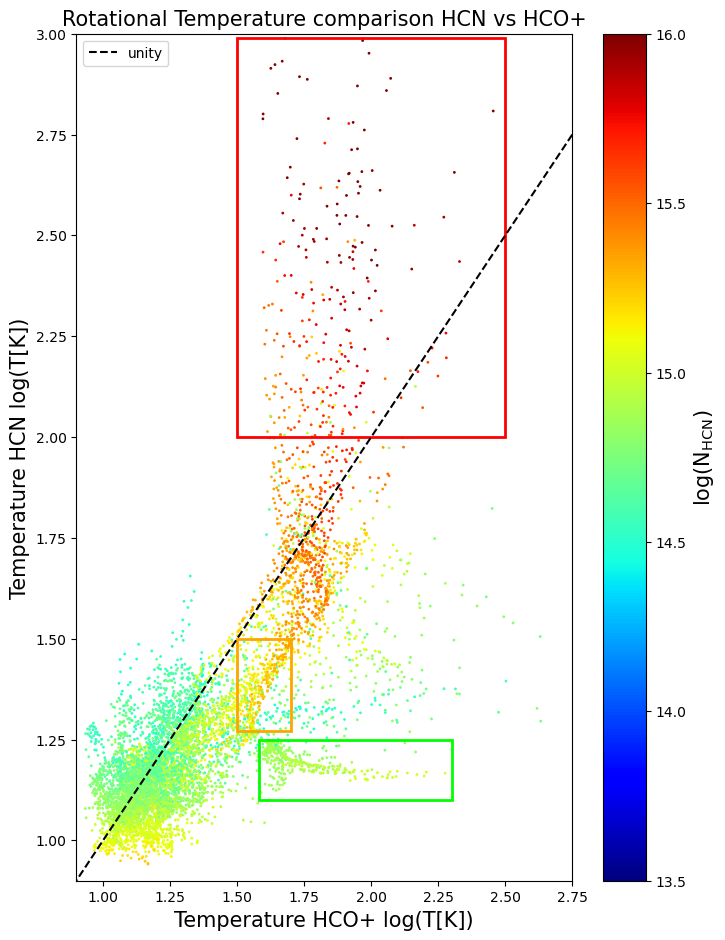

In [75]:
plt.figure(figsize=(8,11))
plt.title('Rotational Temperature comparison HCN vs HCO+', fontsize=15)
sc = plt.scatter(np.log10(Tk_HCOp_behaved.value),  np.log10(Tk_HCN_behaved.value), cmap='jet', vmin=13.5, vmax=16, c=np.log10(N_B6_HCN.value), s=1)
plt.plot([0,3],[0,3], color='black', linestyle='dashed', label='unity')
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((low_x1, low_y1), low_x2-low_x1, low_y2-low_y1,
                      alpha=1, facecolor='none', edgecolor='lime', linewidth=2))
currentAxis.add_patch(Rectangle((up_x1, up_y1), up_x2-up_x1, up_y2-up_y1,
                      alpha=1, facecolor='none', edgecolor='orange', linewidth=2))
currentAxis.add_patch(Rectangle((high_x1, high_y1), high_x2-high_x1, high_y2-high_y1,
                      alpha=1, facecolor='none', edgecolor='red', linewidth=2))
plt.xlabel('Temperature HCO+ log(T[K])', fontsize=15)
plt.ylabel('Temperature HCN log(T[K])', fontsize=15)
cbar = plt.colorbar(sc)
cbar.set_label('log(N$_{\mathrm{HCN}}$)', fontsize=15)
plt.legend(loc='upper left')
plt.xlim(0.9,2.75)
plt.ylim(0.9,3)
plt.savefig('correlationplot_temp.pdf')

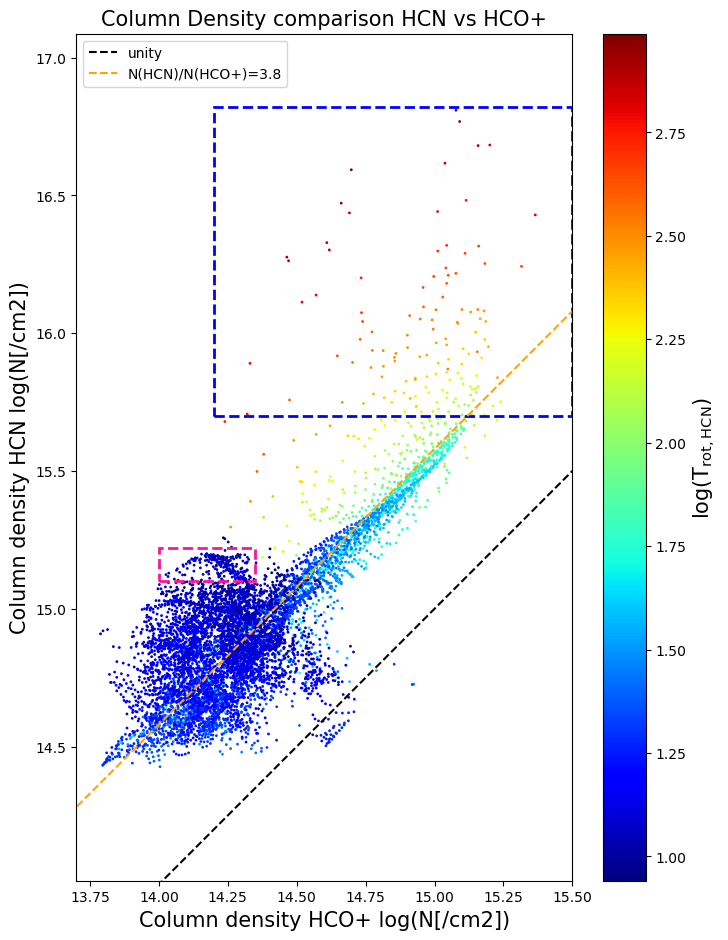

In [76]:
plt.figure(figsize=(8,11))
plt.title('Column Density comparison HCN vs HCO+', fontsize=15)
plt.axis('equal')
sc = plt.scatter(np.log10(N_B6_HCOp.value),  np.log10(N_B6_HCN.value), c=np.log10(Tk_HCN_behaved.value), cmap='jet', s=1)
plt.plot([0,17],[0,17], color='black', linestyle='dashed', label='unity')
plt.plot([0,17],[0.58,17.58], color='orange', linestyle='dashed', label='N(HCN)/N(HCO+)=3.8')
currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((coldens_x1, coldens_y1), coldens_x2-coldens_x1, coldens_y2-coldens_y1,
#                      alpha=1, facecolor='none', edgecolor='black'))
currentAxis.add_patch(Rectangle((coldens2_x1, coldens2_y1), coldens2_x2-coldens2_x1, coldens2_y2-coldens2_y1,
                      alpha=1, facecolor='none', edgecolor='deeppink', linestyle='dashed', linewidth=2))
currentAxis.add_patch(Rectangle((coldens3_x1, coldens3_y1), coldens3_x2-coldens3_x1, coldens3_y2-coldens3_y1,
                      alpha=1, facecolor='none', edgecolor='blue', linestyle='dashed', linewidth=2))
plt.xlabel('Column density HCO+ log(N[/cm2])', fontsize=15)
plt.ylabel('Column density HCN log(N[/cm2])', fontsize=15)
cbar = plt.colorbar(sc)
cbar.set_label('log(T$_{\mathrm{rot,HCN}}$)', fontsize=15)
plt.legend(loc='upper left')
plt.xlim(13.7,15.5)
plt.ylim(14.3,16.8)
plt.savefig('correlationplot_dens.pdf')

C:\Users\woutg\anaconda3\lib\site-packages\astropy\visualization\wcsaxes\core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
C:\Users\woutg\AppData\Local\Temp\ipykernel_6460\3408050925.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


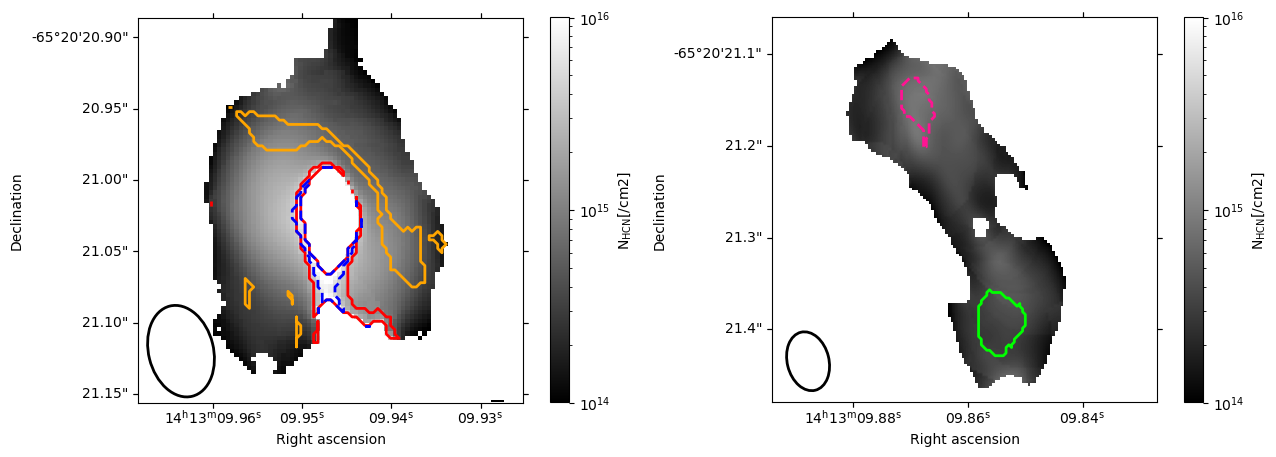

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), subplot_kw={'projection': wcs_B6})

beam_HCN_0 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_1 = Ellipse((613, 365), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)

ax[0].contour(np.logical_not(region_coldens3), 0, zorder=2, linestyles='dashed', linewidths=2, colors='blue')
ax[0].contour(np.logical_not(region_up), 0, zorder=1, linewidths=2, colors='orange')
ax[0].contour(np.logical_not(region_high), 0, zorder=1, linewidths=2, colors='red')
ax[0].imshow(np.log10(N_B6_HCN.value), vmin=14.5, vmax=16, cmap='gray', origin='lower', zorder=0)
ax[0].set_xlabel('Right ascension')
ax[0].set_ylabel('Declination')
ax[0].set_xlim(445,535)
ax[0].set_ylim(458,548)
ax[0].add_patch(beam_HCN_0)
fig.colorbar(mappable=cm.ScalarMappable(norm=norm_d, cmap='gray'), ax=ax[0], label='N$_{\mathrm{HCN}}$[/cm2]')

ax[1].contour(np.logical_not(region_coldens2), 0, zorder=2, linewidths=2, colors='deeppink', linestyles='dashed')
ax[1].contour(np.logical_not(region_low), 0, zorder=1, linewidths=2, colors='lime')
ax[1].imshow(np.log10(N_B6_HCN.value), vmin=14.5, vmax=16, cmap='gray', origin='lower', zorder=0)
ax[1].set_xlabel('Right ascension')
ax[1].set_ylabel('Declination')
ax[1].set_xlim(600,740)
ax[1].set_ylim(350,490)
ax[1].add_patch(beam_HCN_1)
fig.colorbar(mappable=cm.ScalarMappable(norm=norm_d, cmap='gray'), ax=ax[1], label='N$_{\mathrm{HCN}}$[/cm2]')
plt.tight_layout()
plt.savefig('regions_interest.pdf', bbox_inches='tight')

# Aperture RADEX coldens 1

In [26]:
def aper(regname, mmap):
    reg = Regions.read(regname, format='ds9')
    reg_pix = SkyCircularAperture(reg[0].center, r=reg[0].radius).to_pixel(wcs_B6)
    reg_stats = ApertureStats(mmap.value, reg_pix)
    reg_mean = reg_stats.mean
    reg_std = reg_stats.std
    return reg_mean, reg_std

def stat(regname):
    reg_T_HCN_mean, reg_T_HCN_std = aper(regname, Tk_HCN_behaved)
    reg_N_HCN_mean, reg_N_HCN_std = aper(regname, N_B6_HCN)
    reg_T_HCOp_mean, reg_T_HCOp_std = aper(regname, Tk_HCOp_behaved)
    reg_N_HCOp_mean, reg_N_HCOp_std = aper(regname, N_B6_HCOp)
    output = np.array([[reg_T_HCN_mean, reg_T_HCN_std], [reg_N_HCN_mean, reg_N_HCN_std],\
                      [reg_T_HCOp_mean, reg_T_HCOp_std], [reg_N_HCOp_mean, reg_N_HCOp_std]])
    return output

stat_B1 = stat('B1_region_circular')
stat_B2 = stat('B2_region_circular')
stat_B3 = stat('B3_region_circular')

order = [['T HCN', 'T HCN std'],['N HCN', 'N HCN std'],['T HCOp', 'T HCOp std'],['N HCOp', 'N HCOp std']]

np.save('B1_stat.npy', stat_B1)
np.save('B2_stat.npy', stat_B2)
np.save('B3_stat.npy', stat_B3)
np.save('order_stat.npy', order)

print(stat_B1)
print(stat_B2)
print(stat_B3)
print(order)

C:\Users\woutg\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


[[1.42731218e+01 2.38450018e+00]
 [1.04566033e+15 2.76467865e+14]
 [1.58077721e+01 2.67219576e+00]
 [1.66358711e+14 3.75445422e+13]]
[[1.67918280e+01 4.64942053e+00]
 [6.77444086e+14 1.67332531e+14]
 [1.74717601e+01 3.27482754e+00]
 [1.44198944e+14 3.92421865e+13]]
[[1.61618092e+01 2.48440558e+00]
 [7.49032975e+14 1.70549809e+14]
 [5.62301949e+01 2.15553661e+01]
 [1.31627492e+14 2.28830871e+13]]
[['T HCN', 'T HCN std'], ['N HCN', 'N HCN std'], ['T HCOp', 'T HCOp std'], ['N HCOp', 'N HCOp std']]


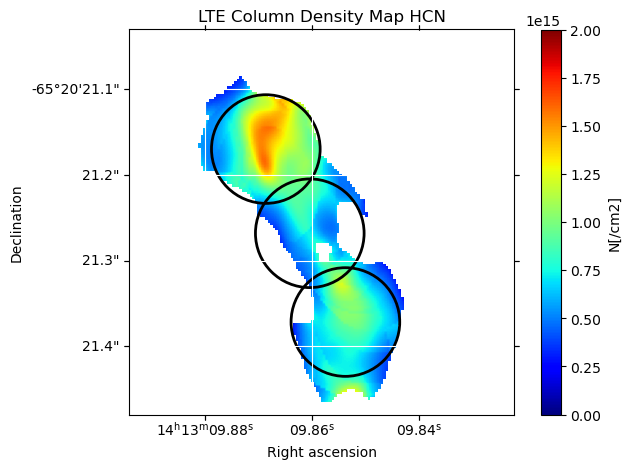

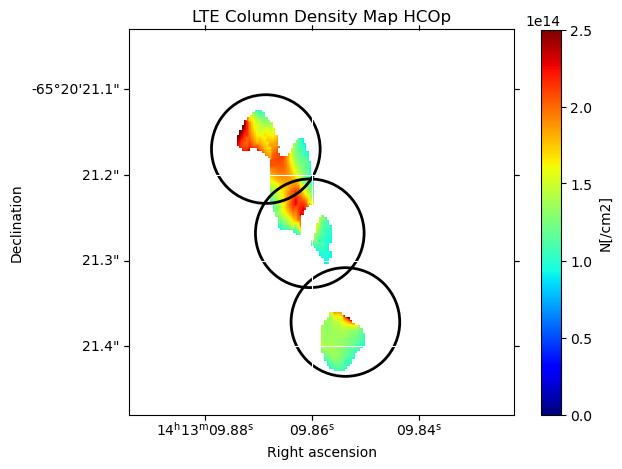

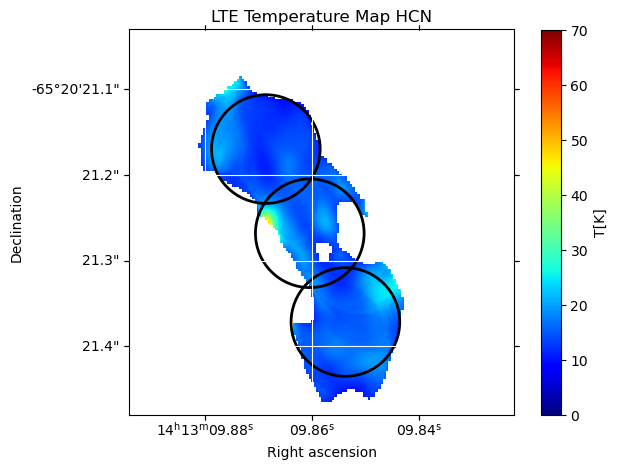

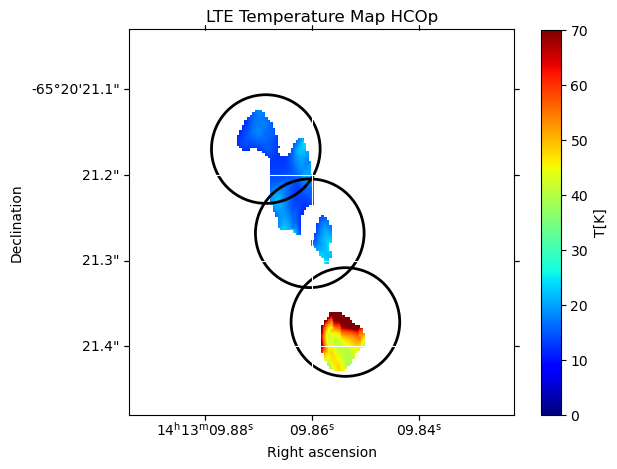

In [27]:
B1_reg = Regions.read('B1_region_circular', format='ds9')
B1_reg_pix = SkyCircularAperture(B1_reg[0].center, r=B1_reg[0].radius).to_pixel(wcs_B6)
   
B2_reg = Regions.read('B2_region_circular', format='ds9')
B2_reg_pix = SkyCircularAperture(B2_reg[0].center, r=B2_reg[0].radius).to_pixel(wcs_B6)
    
B3_reg = Regions.read('B3_region_circular', format='ds9')
B3_reg_pix = SkyCircularAperture(B3_reg[0].center, r=B3_reg[0].radius).to_pixel(wcs_B6)
    
plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(N_B6_HCN.value, vmin=0 , vmax=2e15, origin='lower', cmap='jet')
B1_reg_pix.plot(color='black', lw=2, label='B1 aperture')
B2_reg_pix.plot(color='black', lw=2, label='B2 aperture')
B3_reg_pix.plot(color='black', lw=2, label='B3 aperture')
plt.title('LTE Column Density Map HCN')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.xlim(600,750)
plt.ylim(350,500)
plt.colorbar(label='N[/cm2]')
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(N_B6_HCOp.value, vmin=0 , vmax=2.5e14, origin='lower', cmap='jet')
B1_reg_pix.plot(color='black', lw=2, label='B1 aperture')
B2_reg_pix.plot(color='black', lw=2, label='B2 aperture')
B3_reg_pix.plot(color='black', lw=2, label='B3 aperture')
plt.title('LTE Column Density Map HCOp')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.xlim(600,750)
plt.ylim(350,500)
plt.colorbar(label='N[/cm2]')
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(Tk_HCN.value, vmin=0, vmax=70, origin='lower', cmap='jet')
B1_reg_pix.plot(color='black', lw=2, label='B1 aperture')
B2_reg_pix.plot(color='black', lw=2, label='B2 aperture')
B3_reg_pix.plot(color='black', lw=2, label='B3 aperture')
plt.title('LTE Temperature Map HCN')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.xlim(600,750)
plt.ylim(350,500)
plt.colorbar(label='T[K]')
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(Tk_HCOp.value, vmin=0, vmax=70, origin='lower', cmap='jet')
B1_reg_pix.plot(color='black', lw=2, label='B1 aperture')
B2_reg_pix.plot(color='black', lw=2, label='B2 aperture')
B3_reg_pix.plot(color='black', lw=2, label='B3 aperture')
plt.title('LTE Temperature Map HCOp')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.xlim(600,750)
plt.ylim(350,500)
plt.colorbar(label='T[K]')
plt.show()

# Line Ratios:

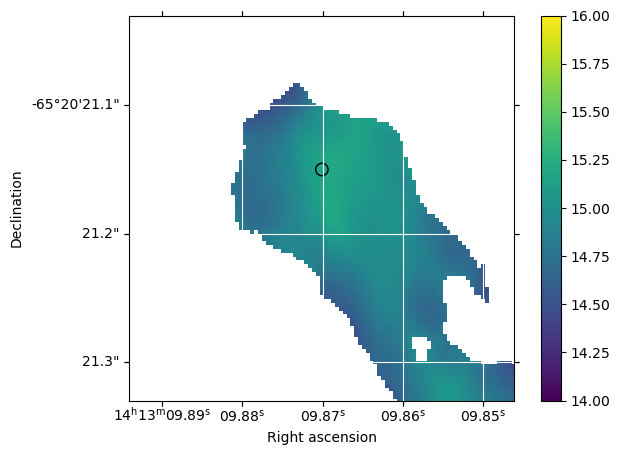

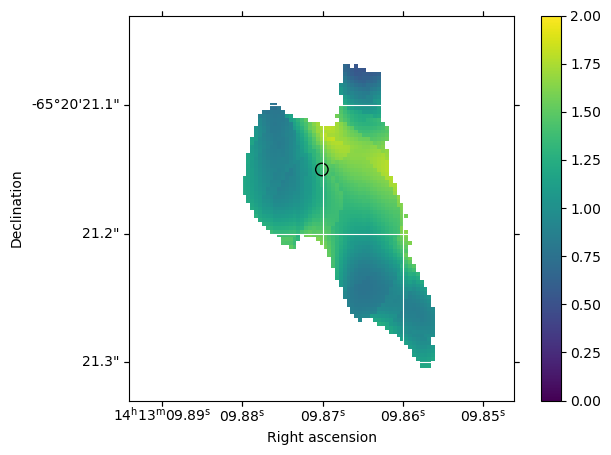

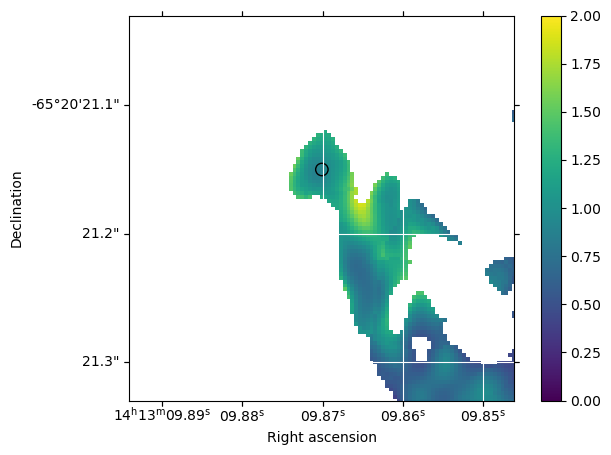

In [28]:
plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(np.log10(N_B6_HCN.value), vmin=14, vmax=16, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.colorbar()
plt.scatter(650,460, s=80, facecolors='none', edgecolors='black')
plt.xlim(600,700)
plt.ylim(400,500)
plt.show()

ratio_32 = B6_HCN_clip.value/B6_HCOp_clip.value
ratio_43 = B7_HCN_clip.value/B7_HCOp_clip.value

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(ratio_32, vmin=0, vmax=2, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.colorbar()
plt.scatter(650,460, s=80, facecolors='none', edgecolors='black')
plt.xlim(600,700)
plt.ylim(400,500)
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(ratio_43, vmin=0, vmax=2, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.colorbar()
plt.scatter(650,460, s=80, facecolors='none', edgecolors='black')
plt.xlim(600,700)
plt.ylim(400,500)
plt.show()

# Aperture RADEX coldens 2

In [29]:
B1_reg = Regions.read('B1_region_circular', format='ds9')
B1_reg_pix = SkyCircularAperture(B1_reg[0].center, r=B1_reg[0].radius).to_pixel(wcs_B6)
   
B2_reg = Regions.read('B2_region_circular', format='ds9')
B2_reg_pix = SkyCircularAperture(B2_reg[0].center, r=B2_reg[0].radius).to_pixel(wcs_B6)
    
B3_reg = Regions.read('B3_region_circular', format='ds9')
B3_reg_pix = SkyCircularAperture(B3_reg[0].center, r=B3_reg[0].radius).to_pixel(wcs_B6)

In [30]:
import astropy.io.fits as fits
import astropy.wcs as wcs
from regions import PixCoord, PointSkyRegion, PointPixelRegion, CirclePixelRegion
from astropy.coordinates import SkyCoord

B1_point_pix = CirclePixelRegion(center=PixCoord(x=651, y=459),radius=0.1)#PointPixelRegion
B2_point_pix = CirclePixelRegion(center=PixCoord(x=675, y=420),radius=0.1)
B3_point_pix = CirclePixelRegion(center=PixCoord(x=685, y=385),radius=0.1)

B1_circ_pix = CirclePixelRegion(center=PixCoord(x=651, y=459),radius=15)
B2_circ_pix = CirclePixelRegion(center=PixCoord(x=675, y=420),radius=15)
B3_circ_pix = CirclePixelRegion(center=PixCoord(x=685, y=385),radius=15)

B1_point_pix.to_sky(wcs_B6).write('B1_point.reg', format='ds9', overwrite=True)
B2_point_pix.to_sky(wcs_B6).write('B2_point.reg', format='ds9', overwrite=True)
B3_point_pix.to_sky(wcs_B6).write('B3_point.reg', format='ds9', overwrite=True)

B1_circ_pix.to_sky(wcs_B6).write('B1_circ.reg', format='ds9', overwrite=True)
B2_circ_pix.to_sky(wcs_B6).write('B2_circ.reg', format='ds9', overwrite=True)
B3_circ_pix.to_sky(wcs_B6).write('B3_circ.reg', format='ds9', overwrite=True)

D1_point_pix = CirclePixelRegion(center=PixCoord(x=576, y=527),radius=0.1)
D2_point_pix = CirclePixelRegion(center=PixCoord(x=551, y=560),radius=0.1)
D3_point_pix = CirclePixelRegion(center=PixCoord(x=525, y=595),radius=0.1)
D4_point_pix = CirclePixelRegion(center=PixCoord(x=510, y=567),radius=0.1)
D5_point_pix = CirclePixelRegion(center=PixCoord(x=495, y=540),radius=0.1)

D1_circ_pix = CirclePixelRegion(center=PixCoord(x=576, y=527),radius=12)
D2_circ_pix = CirclePixelRegion(center=PixCoord(x=551, y=560),radius=12)
D3_circ_pix = CirclePixelRegion(center=PixCoord(x=525, y=595),radius=12)
D4_circ_pix = CirclePixelRegion(center=PixCoord(x=511, y=572),radius=12)
D5_circ_pix = CirclePixelRegion(center=PixCoord(x=496, y=550),radius=12)

D1_point_pix.to_sky(wcs_B6).write('D1_point.reg', format='ds9', overwrite=True)
D2_point_pix.to_sky(wcs_B6).write('D2_point.reg', format='ds9', overwrite=True)
D3_point_pix.to_sky(wcs_B6).write('D3_point.reg', format='ds9', overwrite=True)
D4_point_pix.to_sky(wcs_B6).write('D4_point.reg', format='ds9', overwrite=True)
D5_point_pix.to_sky(wcs_B6).write('D5_point.reg', format='ds9', overwrite=True)

D1_circ_pix.to_sky(wcs_B6).write('D1_circ.reg', format='ds9', overwrite=True)
D2_circ_pix.to_sky(wcs_B6).write('D2_circ.reg', format='ds9', overwrite=True)
D3_circ_pix.to_sky(wcs_B6).write('D3_circ.reg', format='ds9', overwrite=True)
D4_circ_pix.to_sky(wcs_B6).write('D4_circ.reg', format='ds9', overwrite=True)
D5_circ_pix.to_sky(wcs_B6).write('D5_circ.reg', format='ds9', overwrite=True)

C1_point_pix = CirclePixelRegion(center=PixCoord(x=548, y=450),radius=0.1)
C2_point_pix = CirclePixelRegion(center=PixCoord(x=540, y=435),radius=0.1)
C3_point_pix = CirclePixelRegion(center=PixCoord(x=535, y=415),radius=0.1)

C1_point_pix.to_sky(wcs_B6).write('C1_point.reg', format='ds9', overwrite=True)
C2_point_pix.to_sky(wcs_B6).write('C2_point.reg', format='ds9', overwrite=True)
C3_point_pix.to_sky(wcs_B6).write('C3_point.reg', format='ds9', overwrite=True)


def get_ring_points(center, r):
    ring_points = []
    angle_step = np.pi/4
    for i in range(8):
        angle = -i * angle_step + np.pi/2
        x = np.rint(r * np.cos(angle) + center[0])
        y = np.rint(r * np.sin(angle) + center[1])
        ring_points.append((x,y))
    return ring_points

# Peak in continuum fit:
ra_peak = '14:13:09.9473024808'
dec_peak = '-65:20:21.0232432763'
peak_sky = SkyCoord(ra_peak, dec_peak, unit=('hourangle', 'deg'))
x_peak, y_peak = wcs_B6.all_world2pix(peak_sky.ra.deg, peak_sky.dec.deg, 0)

E_center_pix = PointPixelRegion(center=PixCoord(x=np.rint(x_peak), y=np.rint(y_peak)))
E_center_pix.write('E_center.reg', format='ds9', overwrite=True)
ring_1 = get_ring_points((490,503),12)
ring_2 = get_ring_points((490,503),24)

E11_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[0][0], y=ring_1[0][1]),radius=0.1)
E12_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[1][0], y=ring_1[1][1]),radius=0.1)
E13_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[2][0], y=ring_1[2][1]),radius=0.1)
E14_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[3][0], y=ring_1[3][1]),radius=0.1)
E15_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[4][0], y=ring_1[4][1]),radius=0.1)
E16_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[5][0], y=ring_1[5][1]),radius=0.1)
E17_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[6][0], y=ring_1[6][1]),radius=0.1)
E18_point_pix = CirclePixelRegion(center=PixCoord(x=ring_1[7][0], y=ring_1[7][1]),radius=0.1)

E21_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[0][0], y=ring_2[0][1]),radius=0.1)
E22_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[1][0], y=ring_2[1][1]),radius=0.1)
E23_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[2][0], y=ring_2[2][1]),radius=0.1)
E24_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[3][0], y=ring_2[3][1]),radius=0.1)
E25_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[4][0], y=ring_2[4][1]),radius=0.1)
E26_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[5][0], y=ring_2[5][1]),radius=0.1)
E27_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[6][0], y=ring_2[6][1]),radius=0.1)
E28_point_pix = CirclePixelRegion(center=PixCoord(x=ring_2[7][0], y=ring_2[7][1]),radius=0.1)

E11_point_pix.to_sky(wcs_B6).write('E11_point.reg', format='ds9', overwrite=True)
E12_point_pix.to_sky(wcs_B6).write('E12_point.reg', format='ds9', overwrite=True)
E13_point_pix.to_sky(wcs_B6).write('E13_point.reg', format='ds9', overwrite=True)
E14_point_pix.to_sky(wcs_B6).write('E14_point.reg', format='ds9', overwrite=True)
E15_point_pix.to_sky(wcs_B6).write('E15_point.reg', format='ds9', overwrite=True)
E16_point_pix.to_sky(wcs_B6).write('E16_point.reg', format='ds9', overwrite=True)
E17_point_pix.to_sky(wcs_B6).write('E17_point.reg', format='ds9', overwrite=True)
E18_point_pix.to_sky(wcs_B6).write('E18_point.reg', format='ds9', overwrite=True)

E21_point_pix.to_sky(wcs_B6).write('E21_point.reg', format='ds9', overwrite=True)
E22_point_pix.to_sky(wcs_B6).write('E22_point.reg', format='ds9', overwrite=True)
E23_point_pix.to_sky(wcs_B6).write('E23_point.reg', format='ds9', overwrite=True)
E24_point_pix.to_sky(wcs_B6).write('E24_point.reg', format='ds9', overwrite=True)
E25_point_pix.to_sky(wcs_B6).write('E25_point.reg', format='ds9', overwrite=True)
E26_point_pix.to_sky(wcs_B6).write('E26_point.reg', format='ds9', overwrite=True)
E27_point_pix.to_sky(wcs_B6).write('E27_point.reg', format='ds9', overwrite=True)
E28_point_pix.to_sky(wcs_B6).write('E28_point.reg', format='ds9', overwrite=True)

A1_point_pix = CirclePixelRegion(center=PixCoord(x=340, y=800),radius=75)
A2_point_pix = CirclePixelRegion(center=PixCoord(x=320, y=650),radius=75)
A3_point_pix = CirclePixelRegion(center=PixCoord(x=330, y=500),radius=75)
A4_point_pix = CirclePixelRegion(center=PixCoord(x=420, y=380),radius=75)

A1_point_pix.to_sky(wcs_B6).write('A1_point.reg', format='ds9', overwrite=True)
A2_point_pix.to_sky(wcs_B6).write('A2_point.reg', format='ds9', overwrite=True)
A3_point_pix.to_sky(wcs_B6).write('A3_point.reg', format='ds9', overwrite=True)
A4_point_pix.to_sky(wcs_B6).write('A4_point.reg', format='ds9', overwrite=True)

F_point_pix = CirclePixelRegion(center=PixCoord(x=355, y=80),radius=30)
F_point_pix.to_sky(wcs_B6).write('F_point.reg', format='ds9', overwrite=True)

In [31]:
print(np.array(ring_1))

[[490. 515.]
 [498. 511.]
 [502. 503.]
 [498. 495.]
 [490. 491.]
 [482. 495.]
 [478. 503.]
 [482. 511.]]


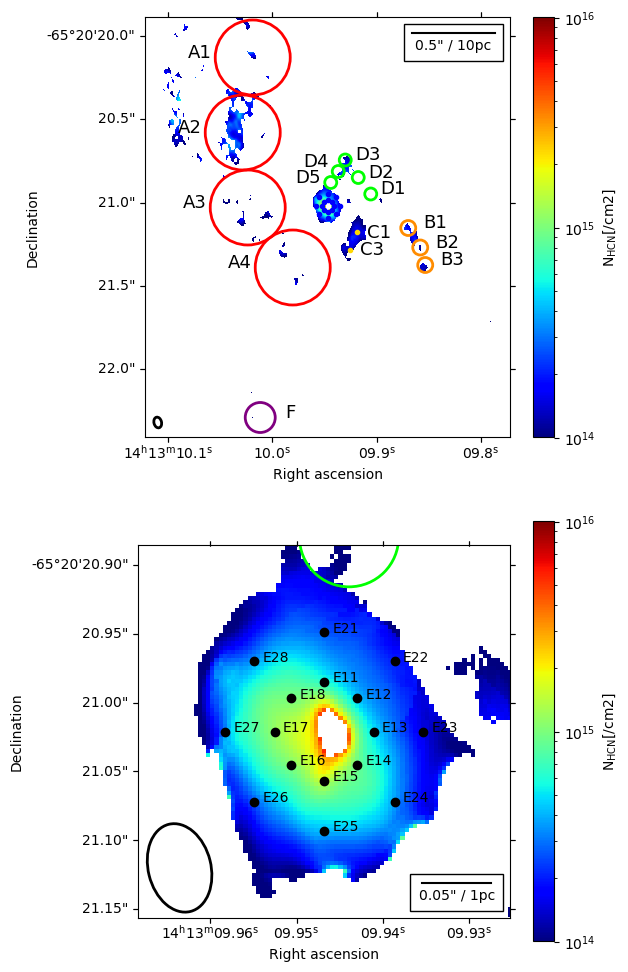

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(6,12), subplot_kw={'projection': wcs_B6})

beam_HCN_00 = Ellipse((ra, 70), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)
beam_HCN_10 = Ellipse((ra_zoom, dec_zoom), beam_minor_pix, beam_major_pix, angle=beam_pa, facecolor='white', edgecolor='black', lw=2, zorder=100)

ax[0].imshow(N_B6_HCOp.value, norm=norm_d, cmap='jet', origin='lower')

A1_point_pix.plot(color='red', lw=2, ax=ax[0])
A2_point_pix.plot(color='red', lw=2, ax=ax[0])
A3_point_pix.plot(color='red', lw=2, ax=ax[0])
A4_point_pix.plot(color='red', lw=2, ax=ax[0])
ax[0].text(340-130, 800, s='A1',fontsize=13)
ax[0].text(320-130, 650, s='A2',fontsize=13)
ax[0].text(330-130, 500, s='A3',fontsize=13)
ax[0].text(420-130, 380, s='A4',fontsize=13)

B1_circ_pix.plot(color='darkorange', lw=2, ax=ax[0])
B2_circ_pix.plot(color='darkorange', lw=2, ax=ax[0])
B3_circ_pix.plot(color='darkorange', lw=2, ax=ax[0])
ax[0].text(651+30, 459, s='B1',fontsize=13)
ax[0].text(675+30, 420, s='B2',fontsize=13)
ax[0].text(685+30, 385, s='B3',fontsize=13)

ax[0].scatter([548,535], [450,415],marker='.', color='gold')
ax[0].text(548+20, 450-10, s='C1',fontsize=13)
ax[0].text(535+20, 415-10, s='C3',fontsize=13)

D1_circ_pix.plot(color='lime', lw=2, ax=ax[0])
D2_circ_pix.plot(color='lime', lw=2, ax=ax[0])
D3_circ_pix.plot(color='lime', lw=2, ax=ax[0])
D4_circ_pix.plot(color='lime', lw=2, ax=ax[0])
D5_circ_pix.plot(color='lime', lw=2, ax=ax[0])
ax[0].text(576+20, 527, s='D1',fontsize=13)
ax[0].text(551+20, 560, s='D2',fontsize=13)
ax[0].text(525+20, 595, s='D3',fontsize=13)
ax[0].text(511-70, 572+10, s='D4',fontsize=13)
ax[0].text(496-70, 550, s='D5',fontsize=13)

ax[0].scatter(np.array(ring_1)[:,0], np.array(ring_1)[:,1],marker='.', color='blue')
ax[0].scatter(np.array(ring_2)[:,0], np.array(ring_2)[:,1],marker='.', color='blue')

F_point_pix.plot(color='purple', lw=2, ax=ax[0])
ax[0].text(355+50, 80, s='F',fontsize=13)

#ax[0].set_title('LTE rotational temperature map HCN')
ax[0].set_xlabel('Right ascension')
ax[0].set_ylabel('Declination')
ax[0].add_patch(beam_HCN_00)
ax[0].set_xlim(125,855)
ax[0].set_ylim(40,880)
ob = AnchoredHScaleBar(size=0.22766, label="0.5\" / 10pc", loc=1, frameon=True,
                       pad=0.6,sep=4, ax=ax[0], linekw=dict(color="black")) 
ax[0].add_artist(ob)
fig.colorbar(mappable=cm.ScalarMappable(norm=norm_d, cmap='jet'), ax=ax[0], label='N$_{\mathrm{HCN}}$[/cm2]')

ax[1].imshow(N_B6_HCOp.value, norm=norm_d, cmap='jet', origin='lower')
ax[1].scatter(np.array(ring_1)[:,0], np.array(ring_1)[:,1],marker='o', color='black')
ax[1].scatter(np.array(ring_2)[:,0], np.array(ring_2)[:,1],marker='o', color='black')

names_E1 = ['E11','E12','E13','E14','E15','E16','E17','E18']
names_E2 = ['E21','E22','E23','E24','E25','E26','E27','E28']
for n in range(8):
    x1,y1 = np.array(ring_1)[n,0], np.array(ring_1)[n,1]
    x2,y2 = np.array(ring_2)[n,0], np.array(ring_2)[n,1]
    ax[1].text(x1+2,y1,s=names_E1[n])
    ax[1].text(x2+2,y2,s=names_E2[n])

D1_circ_pix.plot(color='lime', lw=2, ax=ax[1])
D2_circ_pix.plot(color='lime', lw=2, ax=ax[1])
D3_circ_pix.plot(color='lime', lw=2, ax=ax[1])
D4_circ_pix.plot(color='lime', lw=2, ax=ax[1])
D5_circ_pix.plot(color='lime', lw=2, ax=ax[1])

ax[1].set_xlabel('Right ascension')
ax[1].set_ylabel('Declination')
ax[1].set_xlim(445,535)
ax[1].set_ylim(458,548)
ax[1].add_patch(beam_HCN_10)
ob = AnchoredHScaleBar(size=0.1854, label="0.05\" / 1pc", loc=4, frameon=True,
                       pad=0.6,sep=4, ax=ax[1], linekw=dict(color="black")) 
ax[1].add_artist(ob)
fig.colorbar(mappable=cm.ScalarMappable(norm=norm_d, cmap='jet'), ax=ax[1], label='N$_{\mathrm{HCN}}$[/cm2]')
plt.subplots_adjust(wspace=0.3)
plt.show()
#plt.savefig('non_LTE_regions_vertical.pdf', bbox_inches='tight')

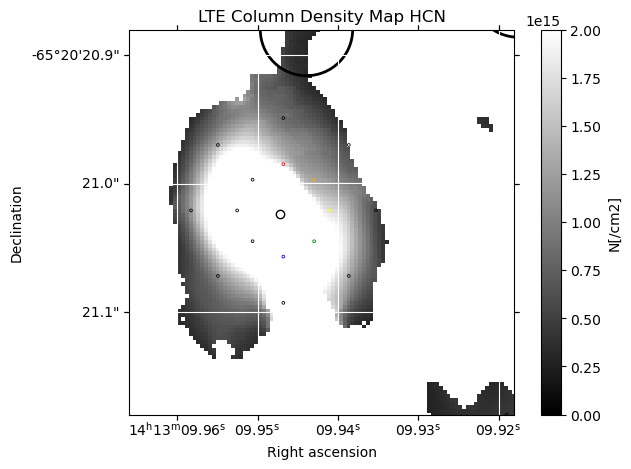

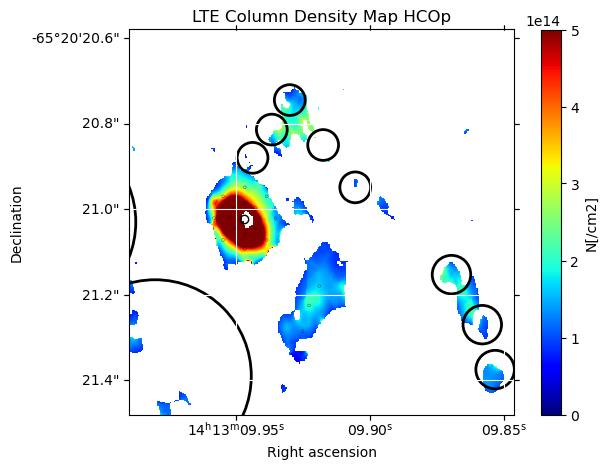

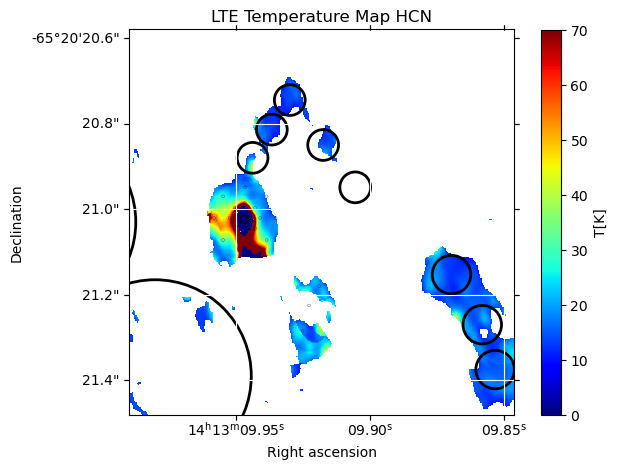

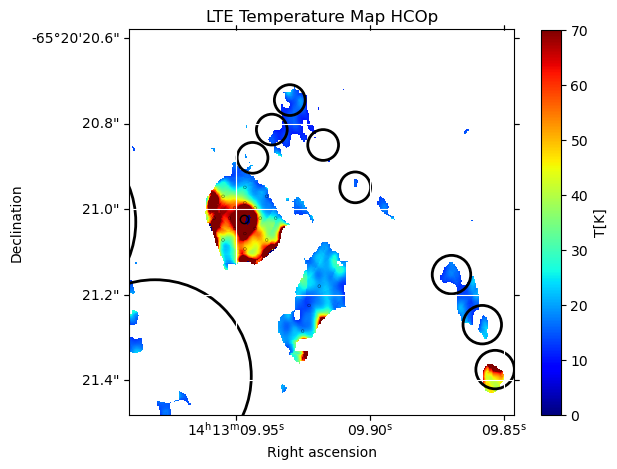

In [37]:
plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(N_B6_HCN.value, vmin=0 , vmax=2e15, origin='lower', cmap='gray')
B1_circ_pix.plot(color='black', lw=2)
B2_circ_pix.plot(color='black', lw=2)
B3_circ_pix.plot(color='black', lw=2)
D1_circ_pix.plot(color='black', lw=2)
D2_circ_pix.plot(color='black', lw=2)
D3_circ_pix.plot(color='black', lw=2)
D4_circ_pix.plot(color='black', lw=2)
D5_circ_pix.plot(color='black', lw=2)
C1_point_pix.plot(color='black', lw=2)
C2_point_pix.plot(color='black', lw=2)
C3_point_pix.plot(color='black', lw=2)
E_center_pix.plot(color='black', lw=2)
E11_point_pix.plot(color='red', lw=2)
E12_point_pix.plot(color='orange', lw=2)
E13_point_pix.plot(color='yellow', lw=2)
E14_point_pix.plot(color='green', lw=2)
E15_point_pix.plot(color='blue', lw=2)
E16_point_pix.plot(color='black', lw=2)
E17_point_pix.plot(color='black', lw=2)
E18_point_pix.plot(color='black', lw=2)
E21_point_pix.plot(color='black', lw=2)
E22_point_pix.plot(color='black', lw=2)
E23_point_pix.plot(color='black', lw=2)
E24_point_pix.plot(color='black', lw=2)
E25_point_pix.plot(color='black', lw=2)
E26_point_pix.plot(color='black', lw=2)
E27_point_pix.plot(color='black', lw=2)
E28_point_pix.plot(color='black', lw=2)
A1_point_pix.plot(color='black', lw=2)
A2_point_pix.plot(color='black', lw=2)
A3_point_pix.plot(color='black', lw=2)
A4_point_pix.plot(color='black', lw=2)
F_point_pix.plot(color='black', lw=2)
plt.title('LTE Column Density Map HCN')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.colorbar(label='N[/cm2]')
plt.xlim(450,550)
plt.ylim(450,550)
plt.savefig('regions_N_HCN_circ.pdf')

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(N_B6_HCOp.value, vmin=0 , vmax=5e14, origin='lower', cmap='jet')
B1_circ_pix.plot(color='black', lw=2)
B2_circ_pix.plot(color='black', lw=2)
B3_circ_pix.plot(color='black', lw=2)
D1_circ_pix.plot(color='black', lw=2)
D2_circ_pix.plot(color='black', lw=2)
D3_circ_pix.plot(color='black', lw=2)
D4_circ_pix.plot(color='black', lw=2)
D5_circ_pix.plot(color='black', lw=2)
C1_point_pix.plot(color='black', lw=2)
C2_point_pix.plot(color='black', lw=2)
C3_point_pix.plot(color='black', lw=2)
E_center_pix.plot(color='black', lw=2)
E11_point_pix.plot(color='black', lw=2)
E12_point_pix.plot(color='black', lw=2)
E13_point_pix.plot(color='black', lw=2)
E14_point_pix.plot(color='black', lw=2)
E15_point_pix.plot(color='black', lw=2)
E16_point_pix.plot(color='black', lw=2)
E17_point_pix.plot(color='black', lw=2)
E18_point_pix.plot(color='black', lw=2)
E21_point_pix.plot(color='black', lw=2)
E22_point_pix.plot(color='black', lw=2)
E23_point_pix.plot(color='black', lw=2)
E24_point_pix.plot(color='black', lw=2)
E25_point_pix.plot(color='black', lw=2)
E26_point_pix.plot(color='black', lw=2)
E27_point_pix.plot(color='black', lw=2)
E28_point_pix.plot(color='black', lw=2)
A1_point_pix.plot(color='black', lw=2)
A2_point_pix.plot(color='black', lw=2)
A3_point_pix.plot(color='black', lw=2)
A4_point_pix.plot(color='black', lw=2)
F_point_pix.plot(color='black', lw=2)

plt.title('LTE Column Density Map HCOp')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.colorbar(label='N[/cm2]')
plt.xlim(400,700)
plt.ylim(350,650)
plt.savefig('regions_N_HCOp_circ.pdf')

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(Tk_HCN.value, vmin=0, vmax=70, origin='lower', cmap='jet')
B1_circ_pix.plot(color='black', lw=2)
B2_circ_pix.plot(color='black', lw=2)
B3_circ_pix.plot(color='black', lw=2)
D1_circ_pix.plot(color='black', lw=2)
D2_circ_pix.plot(color='black', lw=2)
D3_circ_pix.plot(color='black', lw=2)
D4_circ_pix.plot(color='black', lw=2)
D5_circ_pix.plot(color='black', lw=2)
C1_point_pix.plot(color='black', lw=2)
C2_point_pix.plot(color='black', lw=2)
C3_point_pix.plot(color='black', lw=2)
E_center_pix.plot(color='black', lw=2)
E11_point_pix.plot(color='black', lw=2)
E12_point_pix.plot(color='black', lw=2)
E13_point_pix.plot(color='black', lw=2)
E14_point_pix.plot(color='black', lw=2)
E15_point_pix.plot(color='black', lw=2)
E16_point_pix.plot(color='black', lw=2)
E17_point_pix.plot(color='black', lw=2)
E18_point_pix.plot(color='black', lw=2)
E21_point_pix.plot(color='black', lw=2)
E22_point_pix.plot(color='black', lw=2)
E23_point_pix.plot(color='black', lw=2)
E24_point_pix.plot(color='black', lw=2)
E25_point_pix.plot(color='black', lw=2)
E26_point_pix.plot(color='black', lw=2)
E27_point_pix.plot(color='black', lw=2)
E28_point_pix.plot(color='black', lw=2)
A1_point_pix.plot(color='black', lw=2)
A2_point_pix.plot(color='black', lw=2)
A3_point_pix.plot(color='black', lw=2)
A4_point_pix.plot(color='black', lw=2)
F_point_pix.plot(color='black', lw=2)
plt.title('LTE Temperature Map HCN')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.colorbar(label='T[K]')
plt.xlim(400,700)
plt.ylim(350,650)
plt.savefig('regions_T_HCN_circ.pdf')

plt.figure(figsize=(7,5))
plt.subplot(projection=wcs_B6)
plt.imshow(Tk_HCOp.value, vmin=0, vmax=70, origin='lower', cmap='jet')
B1_circ_pix.plot(color='black', lw=2)
B2_circ_pix.plot(color='black', lw=2)
B3_circ_pix.plot(color='black', lw=2)
D1_circ_pix.plot(color='black', lw=2)
D2_circ_pix.plot(color='black', lw=2)
D3_circ_pix.plot(color='black', lw=2)
D4_circ_pix.plot(color='black', lw=2)
D5_circ_pix.plot(color='black', lw=2)
C1_point_pix.plot(color='black', lw=2)
C2_point_pix.plot(color='black', lw=2)
C3_point_pix.plot(color='black', lw=2)
E_center_pix.plot(color='black', lw=2)
E11_point_pix.plot(color='black', lw=2)
E12_point_pix.plot(color='black', lw=2)
E13_point_pix.plot(color='black', lw=2)
E14_point_pix.plot(color='black', lw=2)
E15_point_pix.plot(color='black', lw=2)
E16_point_pix.plot(color='black', lw=2)
E17_point_pix.plot(color='black', lw=2)
E18_point_pix.plot(color='black', lw=2)
E21_point_pix.plot(color='black', lw=2)
E22_point_pix.plot(color='black', lw=2)
E23_point_pix.plot(color='black', lw=2)
E24_point_pix.plot(color='black', lw=2)
E25_point_pix.plot(color='black', lw=2)
E26_point_pix.plot(color='black', lw=2)
E27_point_pix.plot(color='black', lw=2)
E28_point_pix.plot(color='black', lw=2)
A1_point_pix.plot(color='black', lw=2)
A2_point_pix.plot(color='black', lw=2)
A3_point_pix.plot(color='black', lw=2)
A4_point_pix.plot(color='black', lw=2)
F_point_pix.plot(color='black', lw=2)
plt.title('LTE Temperature Map HCOp')
#plt.scatter(500,500, s=80, facecolors='none', edgecolors='black')
plt.grid(color='white', ls='solid')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.colorbar(label='T[K]')
plt.xlim(400,700)
plt.ylim(350,650)
plt.savefig('regions_T_HCOp_circ.pdf')

In [38]:
def aper_2(reg, mmap):
    aper = CircularAperture((reg.center.x, reg.center.y), reg.radius)
    aper_stats = ApertureStats(mmap.value, aper)
    aper_mean = aper_stats.mean
    aper_std = aper_stats.std
    return aper_mean, aper_std

def stat_2(reg):
    reg_T_HCN_mean, reg_T_HCN_std = aper_2(reg, Tk_HCN_behaved)
    reg_N_HCN_mean, reg_N_HCN_std = aper_2(reg, N_B6_HCN)
    reg_T_HCOp_mean, reg_T_HCOp_std = aper_2(reg, Tk_HCOp_behaved)
    reg_N_HCOp_mean, reg_N_HCOp_std = aper_2(reg, N_B6_HCOp)
    output = np.array([[reg_T_HCN_mean, reg_T_HCN_std], [reg_N_HCN_mean, reg_N_HCN_std],\
                      [reg_T_HCOp_mean, reg_T_HCOp_std], [reg_N_HCOp_mean, reg_N_HCOp_std]])
    return output

In [39]:
statistic_A1 = stat_2(A1_point_pix)
statistic_A2 = stat_2(A2_point_pix)
statistic_A3 = stat_2(A3_point_pix)
statistic_A4 = stat_2(A4_point_pix)

statistic_B1 = stat_2(B1_point_pix)
statistic_B2 = stat_2(B2_point_pix)
statistic_B3 = stat_2(B3_point_pix)

statistic_C1 = stat_2(C1_point_pix)
statistic_C2 = stat_2(C2_point_pix)
statistic_C3 = stat_2(C3_point_pix)

statistic_D1 = stat_2(D1_point_pix)
statistic_D2 = stat_2(D2_point_pix)
statistic_D3 = stat_2(D3_point_pix)
statistic_D4 = stat_2(D4_point_pix)
statistic_D5 = stat_2(D5_point_pix)

statistic_E11 = stat_2(E11_point_pix)
statistic_E12 = stat_2(E12_point_pix)
statistic_E13 = stat_2(E13_point_pix)
statistic_E14 = stat_2(E14_point_pix)
statistic_E15 = stat_2(E15_point_pix)
statistic_E15[:2] = statistic_E15[2:] # We use the values for HCOp since HCN has nans because too high rot T
statistic_E16 = stat_2(E16_point_pix)
statistic_E17 = stat_2(E17_point_pix)
statistic_E18 = stat_2(E18_point_pix)
statistic_E21 = stat_2(E21_point_pix)
statistic_E22 = stat_2(E22_point_pix)
statistic_E23 = stat_2(E23_point_pix)
statistic_E24 = stat_2(E24_point_pix)
statistic_E25 = stat_2(E25_point_pix)
statistic_E25[:2] = statistic_E25[2:] # We use the values for HCOp since HCN has nans because too high rot T
statistic_E26 = stat_2(E26_point_pix)
statistic_E27 = stat_2(E27_point_pix)
statistic_E28 = stat_2(E28_point_pix)

statistic_F = stat_2(F_point_pix)

In [43]:
print("{:.6E}".format(statistic_E21[3][0]))
print("{:.6E}".format(statistic_E28[3][0]))
print("{:.6E}".format(statistic_C1[3][0]))

2.644661E+14
3.461891E+14
1.672301E+14


In [40]:
np.save('statistic_A1.npy', statistic_A1)
np.save('statistic_A2.npy', statistic_A2)
np.save('statistic_A3.npy', statistic_A3)
np.save('statistic_A4.npy', statistic_A4)

np.save('statistic_B1.npy', statistic_B1)
np.save('statistic_B2.npy', statistic_B2)
np.save('statistic_B3.npy', statistic_B3)

np.save('statistic_C1.npy', statistic_C1)
np.save('statistic_C2.npy', statistic_C2)
np.save('statistic_C3.npy', statistic_C3)

np.save('statistic_D1.npy', statistic_D1)
np.save('statistic_D2.npy', statistic_D2)
np.save('statistic_D3.npy', statistic_D3)
np.save('statistic_D4.npy', statistic_D4)
np.save('statistic_D5.npy', statistic_D5)

np.save('statistic_E11.npy', statistic_E11)
np.save('statistic_E12.npy', statistic_E12)
np.save('statistic_E13.npy', statistic_E13)
np.save('statistic_E14.npy', statistic_E14)
np.save('statistic_E15.npy', statistic_E15)
np.save('statistic_E16.npy', statistic_E16)
np.save('statistic_E17.npy', statistic_E17)
np.save('statistic_E18.npy', statistic_E18)
np.save('statistic_E21.npy', statistic_E21)
np.save('statistic_E22.npy', statistic_E22)
np.save('statistic_E23.npy', statistic_E23)
np.save('statistic_E24.npy', statistic_E24)
np.save('statistic_E25.npy', statistic_E25)
np.save('statistic_E26.npy', statistic_E26)
np.save('statistic_E27.npy', statistic_E27)
np.save('statistic_E28.npy', statistic_E28)

np.save('statistic_F.npy', statistic_F)

In [41]:
print(statistic_E17)

[[5.69432741e+01 0.00000000e+00]
 [3.91070495e+15 0.00000000e+00]
 [6.67747144e+01 0.00000000e+00]
 [1.12948371e+15 0.00000000e+00]]
